# Computing article quality for all languages using Isaac's model

**WARNING** : This notebok takes around 20 hours for running, and uses a lot of resources, don't run it unless is needed and you know what your doing.

## Updates
* In this version we are adding the new regular expressions for counting media contained in templates
* With this updates, the parsing should be the same existing in this end point: https://misalignment.wmcloud.org/api/v1/quality-revid?

## Procedure
* First we extract the features for all revisions in all language. 
* We store the revisions in _article_quality/features_all.parquet_
* Next, we get the weights for each project and compute article quality at the same time.
* Results are save them in _article_quality/scores_all.parquet_
* Finally we partition by wiki_db and year and store the results in  _article_quality/scores_all_partitioned_by_wiki_and_year.parquet_
* At the end we also add revision_parent_id and compute quality changes in a given revision


In [1]:
%%time
import wmfdata
spark = wmfdata.spark.get_custom_session(
    master="yarn",
    app_name = 'article_quality_all_wikis',
    spark_config={
        # Enough memory on the driver to cache
        # and serialize the encoder.
        "spark.driver.memory": "8g",
        # Increase this if you want to speed things up
        "spark.dynamicAllocation.maxExecutors": 128,
        # Enough memory on each executor to be able
        "spark.executor.memory": "12g",
        # Too many cores in the presence of a big
        # running out of memory.
        "spark.executor.cores": 12,
        "spark.executor.memoryOverhead": "4000M",
    },
)
import pyspark.sql.functions as f

outputHDFS = 'article_quality'
!hadoop fs -mkdir $outputHDFS

You are using wmfdata v1.3.2, but v2.0.0 is available.

To update, run `pip install --upgrade git+https://github.com/wikimedia/wmfdata-python.git@release --ignore-installed`.

To see the changes, refer to https://github.com/wikimedia/wmfdata-python/blob/release/CHANGELOG.md
PySpark executors will use /usr/lib/anaconda-wmf/bin/python3.


mkdir: `article_quality': File exists
CPU times: user 2.58 s, sys: 2.28 s, total: 4.86 s
Wall time: 15.2 s


In [2]:
%%time
MEDIA_PREFIXES = ['File', 'Image', 'Media']
CAT_PREFIXES = ['Category']

MEDIA_ALIASES = {
    "ab": ["Медиа", "Файл", "Афаил", "Амедиа", "Изображение"],
    "ace": ["Beureukaih", "Gambar", "Alat", "Berkas"],
    "ady": ["Медиа"],
    "af": ["Lêer", "Beeld"],
    "als": ["Medium", "Datei", "Bild"],
    "am": ["ፋይል", "ስዕል"],
    "an": ["Imachen", "Imagen"],
    "ang": ["Ymele", "Biliþ"],
    "ar": ["ميديا", "صورة", "وسائط", "ملف"],
    "arc": ["ܠܦܦܐ", "ܡܝܕܝܐ"],
    "arz": ["ميديا", "صورة", "وسائط", "ملف"],
    "as": ["চিত্ৰ", "चित्र", "চিত্র", "মাধ্যম"],
    "ast": ["Imaxen", "Ficheru", "Imaxe", "Archivu", "Imagen", "Medios"],
    "atj": ["Tipatcimoctakewin", "Natisinahikaniwoc"],
    "av": ["Медиа", "Файл", "Изображение"],
    "ay": ["Medio", "Archivo", "Imagen"],
    "az": ["Mediya", "Şəkil", "Fayl"],
    "azb": ["رسانه", "تصویر", "مدیا", "فایل", "رسانه‌ای"],
    "ba": ["Медиа", "Рәсем", "Файл", "Изображение"],
    "bar": ["Medium", "Datei", "Bild"],
    "bat-smg": ["Vaizdas", "Medėjė", "Abruozdielis"],
    "bcl": ["Medio", "Ladawan"],
    "be": ["Мультымедыя", "Файл", "Выява"],
    "be-x-old": ["Мэдыя", "Файл", "Выява"],
    "bg": ["Медия", "Файл", "Картинка"],
    "bh": ["मीडिया", "चित्र"],
    "bjn": ["Barakas", "Gambar", "Berkas"],
    "bm": ["Média", "Fichier"],
    "bn": ["চিত্র", "মিডিয়া"],
    "bpy": ["ছবি", "মিডিয়া"],
    "br": ["Skeudenn", "Restr"],
    "bs": ["Mediji", "Slika", "Datoteka", "Medija"],
    "bug": ["Gambar", "Berkas"],
    "bxr": ["Файл", "Меди", "Изображение"],
    "ca": ["Fitxer", "Imatge"],
    "cbk-zam": ["Medio", "Archivo", "Imagen"],
    "cdo": ["文件", "媒體", "圖像", "檔案"],
    "ce": ["Хlум", "Медиа", "Сурт", "Файл", "Медйа", "Изображение"],
    "ceb": ["Payl", "Medya", "Imahen"],
    "ch": ["Litratu"],
    "ckb": ["میدیا", "پەڕگە"],
    "co": ["Immagine"],
    "crh": ["Медиа", "Resim", "Файл", "Fayl", "Ресим"],
    "cs": ["Soubor", "Média", "Obrázok"],
    "csb": ["Òbrôzk", "Grafika"],
    "cu": ["Видъ", "Ви́дъ", "Дѣло", "Срѣдьства"],
    "cv": ["Медиа", "Ӳкерчĕк", "Изображение"],
    "cy": ["Delwedd"],
    "da": ["Billede", "Fil"],
    "de": ["Medium", "Datei", "Bild"],
    "din": ["Ciɛl", "Apamduööt"],
    "diq": ["Medya", "Dosya"],
    "dsb": ["Wobraz", "Dataja", "Bild", "Medija"],
    "dty": ["चित्र", "मिडिया"],
    "dv": ["ފައިލު", "މީޑިއާ", "ފައިލް"],
    "el": ["Εικόνα", "Αρχείο", "Μέσο", "Μέσον"],
    "eml": ["Immagine"],
    "eo": ["Dosiero", "Aŭdvidaĵo"],
    "es": ["Medio", "Archivo", "Imagen"],
    "et": ["Pilt", "Fail", "Meedia"],
    "eu": ["Irudi", "Fitxategi"],
    "ext": ["Archivu", "Imagen", "Mediu"],
    "fa": ["رسانه", "تصویر", "مدیا", "پرونده", "رسانه‌ای"],
    "ff": ["Média", "Fichier"],
    "fi": ["Kuva", "Tiedosto"],
    "fiu-vro": ["Pilt", "Meediä"],
    "fo": ["Miðil", "Mynd"],
    "fr": ["Média", "Fichier"],
    "frp": ["Émâge", "Fichiér", "Mèdia"],
    "frr": ["Medium", "Datei", "Bild"],
    "fur": ["Immagine", "Figure"],
    "fy": ["Ofbyld"],
    "ga": ["Íomhá", "Meán"],
    "gag": ["Mediya", "Medya", "Resim", "Dosya", "Dosye"],
    "gan": ["媒体文件", "文件", "文檔", "档案", "媒體", "图像", "圖像", "媒体", "檔案"],
    "gd": ["Faidhle", "Meadhan"],
    "gl": ["Imaxe", "Ficheiro", "Arquivo", "Imagem"],
    "glk": ["رسانه", "تصویر", "پرونده", "فاىل", "رسانه‌ای", "مديا"],
    "gn": ["Medio", "Imagen", "Ta'ãnga"],
    "gom": ["माध्यम", "मिडिया", "फायल"],
    "gor": ["Gambar", "Berkas"],
    "got": ["𐍆𐌴𐌹𐌻𐌰"],
    "gu": ["દ્રશ્ય-શ્રાવ્ય (મિડિયા)", "દ્રશ્ય-શ્રાવ્ય_(મિડિયા)", "ચિત્ર"],
    "gv": ["Coadan", "Meanyn"],
    "hak": ["文件", "媒體", "圖像", "檔案"],
    "haw": ["Kiʻi", "Waihona", "Pāpaho"],
    "he": ["תמונה", "קו", "מדיה", "קובץ"],
    "hi": ["मीडिया", "चित्र"],
    "hif": ["file", "saadhan"],
    "hr": ["Mediji", "DT", "Slika", "F", "Datoteka"],
    "hsb": ["Wobraz", "Dataja", "Bild"],
    "ht": ["Imaj", "Fichye", "Medya"],
    "hu": ["Kép", "Fájl", "Média"],
    "hy": ["Պատկեր", "Մեդիա"],
    "ia": ["Imagine", "Multimedia"],
    "id": ["Gambar", "Berkas"],
    "ig": ["Nká", "Midia", "Usòrò", "Ákwúkwó orünotu", "Ákwúkwó_orünotu"],
    "ii": ["媒体文件", "文件", "档案", "图像", "媒体"],
    "ilo": ["Midia", "Papeles"],
    "inh": ["Медиа", "Файл", "Изображение"],
    "io": ["Imajo", "Arkivo"],
    "is": ["Miðill", "Mynd"],
    "it": ["Immagine"],
    "ja": ["メディア", "ファイル", "画像"],
    "jbo": ["velsku", "datnyvei"],
    "jv": ["Barkas", "Medhia", "Gambar", "Médhia"],
    "ka": ["მედია", "სურათი", "ფაილი"],
    "kaa": ["Swret", "Таспа", "سۋرەت", "Taspa", "Su'wret", "Сурет", "تاسپا"],
    "kab": ["Tugna"],
    "kbd": ["Медиа", "Файл"],
    "kbp": ["Média", "Fichier"],
    "kg": ["Fisye"],
    "kk": ["Swret", "سۋرەت", "Таспа", "Taspa", "Сурет", "تاسپا"],
    "kl": ["Billede", "Fiileq", "Fil"],
    "km": ["ឯកសារ", "រូបភាព", "មេឌា", "មីឌា"],
    "kn": ["ಚಿತ್ರ", "ಮೀಡಿಯ"],
    "ko": ["미디어", "파일", "그림"],
    "koi": ["Медиа", "Файл", "Изображение"],
    "krc": ["Медиа", "Файл", "Изображение"],
    "ks": ["میڈیا", "فَیِل"],
    "ksh": ["Beld", "Meedije", "Medie", "Belld", "Medium", "Datei", "Meedijum", "Bild"],
    "ku": ["میدیا", "پەڕگە", "Medya", "Wêne"],
    "kv": ["Медиа", "Файл", "Изображение"],
    "kw": ["Restren"],
    "ky": ["Медиа", "Файл"],
    "la": ["Imago", "Fasciculus"],
    "lad": ["Dossia", "Medya", "Archivo", "Dosya", "Imagen", "Meddia"],
    "lb": ["Fichier", "Bild"],
    "lbe": ["Медиа", "Сурат", "Изображение"],
    "lez": ["Медиа", "Mediya", "Файл", "Şəkil", "Изображение"],
    "lfn": ["Fix"],
    "li": ["Afbeelding", "Plaetje", "Aafbeilding"],
    "lij": ["Immaggine", "Immagine"],
    "lmo": ["Immagine", "Imàjine", "Archivi"],
    "ln": ["Média", "Fichier"],
    "lo": ["ສື່ອ", "ສື່", "ຮູບ"],
    "lrc": ["رسانه", "تصویر", "رسانه‌ای", "جانیا", "أسگ", "ڤارئسگأر"],
    "lt": ["Vaizdas", "Medija"],
    "ltg": ["Medeja", "Fails"],
    "lv": ["Attēls"],
    "mai": ["मेडिया", "फाइल"],
    "map-bms": ["Barkas", "Medhia", "Gambar", "Médhia"],
    "mdf": ["Медиа", "Няйф", "Изображение"],
    "mg": ["Rakitra", "Sary", "Média"],
    "mhr": ["Медиа", "Файл", "Изображение"],
    "min": ["Gambar", "Berkas"],
    "mk": ["Податотека", "Медија", "Медиум", "Слика"],
    "ml": ["പ്രമാണം", "ചി", "മീഡിയ", "പ്ര", "ചിത്രം"],
    "mn": ["Медиа", "Файл", "Зураг"],
    "mr": ["चित्र", "मिडिया"],
    "mrj": ["Медиа", "Файл", "Изображение"],
    "ms": ["Fail", "Imej"],
    "mt": ["Midja", "Medja", "Stampa"],
    "mwl": ["Multimédia", "Fexeiro", "Ficheiro", "Arquivo", "Imagem"],
    "my": ["ဖိုင်", "မီဒီယာ"],
    "myv": ["Медия", "Артовкс", "Изображение"],
    "mzn": ["رسانه", "تصویر", "مه‌دیا", "مدیا", "پرونده", "رسانه‌ای"],
    "nah": ["Mēdiatl", "Īxiptli", "Imagen"],
    "nap": ["Fiùra", "Immagine"],
    "nds": ["Datei", "Bild"],
    "nds-nl": ["Ofbeelding", "Afbeelding", "Bestaand"],
    "ne": ["मीडिया", "चित्र"],
    "new": ["किपा", "माध्यम"],
    "nl": ["Bestand", "Afbeelding"],
    "nn": ["Fil", "Bilde", "Filpeikar"],
    "no": ["Fil", "Medium", "Bilde"],
    "nov": [],
    "nrm": ["Média", "Fichier"],
    "nso": ["Seswantšho"],
    "nv": ["Eʼelyaaígíí"],
    "oc": ["Imatge", "Fichièr", "Mèdia"],
    "olo": ["Kuva", "Medii", "Failu"],
    "or": ["ମାଧ୍ୟମ", "ଫାଇଲ"],
    "os": ["Ныв", "Медиа", "Файл", "Изображение"],
    "pa": ["ਤਸਵੀਰ", "ਮੀਡੀਆ"],
    "pcd": ["Média", "Fichier"],
    "pdc": ["Medium", "Datei", "Bild", "Feil"],
    "pfl": ["Dadai", "Medium", "Datei", "Bild"],
    "pi": ["मीडिया", "पटिमा"],
    "pl": ["Plik", "Grafika"],
    "pms": ["Figura", "Immagine"],
    "pnb": ["میڈیا", "تصویر", "فائل"],
    "pnt": ["Εικόνα", "Αρχείον", "Εικόναν", "Μέσον"],
    "ps": ["انځور", "رسنۍ", "دوتنه"],
    "pt": ["Multimédia", "Ficheiro", "Arquivo", "Imagem"],
    "qu": ["Midya", "Imagen", "Rikcha"],
    "rm": ["Multimedia", "Datoteca"],
    "rmy": ["Fişier", "Mediya", "Chitro", "Imagine"],
    "ro": ["Fişier", "Imagine", "Fișier"],
    "roa-rup": ["Fişier", "Imagine", "Fișier"],
    "roa-tara": ["Immagine"],
    "ru": ["Медиа", "Файл", "Изображение"],
    "rue": ["Медіа", "Медиа", "Файл", "Изображение", "Зображення"],
    "rw": ["Dosiye", "Itangazamakuru"],
    "sa": ["चित्रम्", "माध्यमम्", "सञ्चिका", "माध्यम", "चित्रं"],
    "sah": ["Миэдьийэ", "Ойуу", "Билэ", "Изображение"],
    "sat": ["ᱨᱮᱫ", "ᱢᱤᱰᱤᱭᱟ"],
    "sc": ["Immàgini"],
    "scn": ["Immagine", "Mmàggini", "Mèdia"],
    "sd": ["عڪس", "ذريعات", "فائل"],
    "se": ["Fiila"],
    "sg": ["Média", "Fichier"],
    "sh": ["Mediji", "Slika", "Медија", "Datoteka", "Medija", "Слика"],
    "si": ["රූපය", "මාධ්‍යය", "ගොනුව"],
    "sk": ["Súbor", "Obrázok", "Médiá"],
    "sl": ["Slika", "Datoteka"],
    "sq": ["Figura", "Skeda"],
    "sr": ["Датотека", "Medij", "Slika", "Медија", "Datoteka", "Медиј", "Medija", "Слика"],
    "srn": ["Afbeelding", "Gefre"],
    "stq": ["Bielde", "Bild"],
    "su": ["Média", "Gambar"],
    "sv": ["Fil", "Bild"],
    "sw": ["Faili", "Picha"],
    "szl": ["Plik", "Grafika"],
    "ta": ["படிமம்", "ஊடகம்"],
    "tcy": ["ಮಾದ್ಯಮೊ", "ಫೈಲ್"],
    "te": ["ఫైలు", "దస్త్రం", "బొమ్మ", "మీడియా"],
    "tet": ["Imajen", "Arquivo", "Imagem"],
    "tg": ["Акс", "Медиа"],
    "th": ["ไฟล์", "สื่อ", "ภาพ"],
    "ti": ["ፋይል", "ሜድያ"],
    "tk": ["Faýl"],
    "tl": ["Midya", "Talaksan"],
    "tpi": ["Fail"],
    "tr": ["Medya", "Resim", "Dosya", "Ortam"],
    "tt": ["Медиа", "Рәсем", "Файл", "Räsem", "Изображение"],
    "ty": ["Média", "Fichier"],
    "tyv": ["Медиа", "Файл", "Изображение"],
    "udm": ["Медиа", "Файл", "Суред", "Изображение"],
    "ug": ["ۋاسىتە", "ھۆججەت"],
    "uk": ["Медіа", "Медиа", "Файл", "Изображение", "Зображення"],
    "ur": ["میڈیا", "تصویر", "وسیط", "زریعہ", "فائل", "ملف"],
    "uz": ["Mediya", "Tasvir", "Fayl"],
    "vec": ["Immagine", "Imàjine", "Mèdia"],
    "vep": ["Pilt", "Fail"],
    "vi": ["Phương_tiện", "Tập_tin", "Hình", "Tập tin", "Phương tiện"],
    "vls": ["Afbeelding", "Ofbeeldienge"],
    "vo": ["Ragiv", "Magod", "Nünamakanäd"],
    "wa": ["Imådje"],
    "war": ["Medya", "Fayl", "Paypay"],
    "wo": ["Xibaarukaay", "Dencukaay"],
    "wuu": ["文件", "档案", "图像", "媒体"],
    "xal": ["Аһар", "Боомг", "Изображение", "Зург"],
    "xmf": ["მედია", "სურათი", "ფაილი"],
    "yi": ["מעדיע", "תמונה", "טעקע", "בילד"],
    "yo": ["Fáìlì", "Amóhùnmáwòrán", "Àwòrán"],
    "za": ["媒体文件", "文件", "档案", "图像", "媒体"],
    "zea": ["Afbeelding", "Plaetje"],
    "zh": ["媒体文件", "F", "文件", "媒體", "档案", "图像", "圖像", "媒体", "檔案"],
    "zh-classical": ["文件", "媒體", "圖像", "檔案"],
    "zh-min-nan": ["tóng-àn", "文件", "媒體", "Mûi-thé", "圖像", "檔案"],
    "zh-yue": ["檔", "档", "文件", "图", "媒體", "圖", "档案", "图像", "圖像", "媒体", "檔案"],
}

CAT_ALIASES = {
    "ab": ["Категория", "Акатегориа"],
    "ace": ["Kawan", "Kategori"],
    "af": ["Kategorie"],
    "ak": ["Nkyekyem"],
    "als": ["Kategorie"],
    "am": ["መደብ"],
    "an": ["Categoría"],
    "ang": ["Flocc"],
    "ar": ["تصنيف"],
    "arc": ["ܣܕܪܐ"],
    "arz": ["تصنيف"],
    "as": ["CAT", "শ্ৰেণী", "श्रेणी", "শ্রেণী"],
    "ast": ["Categoría"],
    "atj": ["Tipanictawin"],
    "av": ["Категория"],
    "ay": ["Categoría"],
    "az": ["Kateqoriya"],
    "azb": ["بؤلمه"],
    "ba": ["Төркөм", "Категория"],
    "bar": ["Kategorie"],
    "bat-smg": ["Kategorija", "Kateguorėjė"],
    "bcl": ["Kategorya"],
    "be": ["Катэгорыя"],
    "be-x-old": ["Катэгорыя"],
    "bg": ["Категория"],
    "bh": ["श्रेणी"],
    "bjn": ["Tumbung", "Kategori"],
    "bm": ["Catégorie"],
    "bn": ["বিষয়শ্রেণী", "വിഭാഗം"],
    "bpy": ["থাক"],
    "br": ["Rummad"],
    "bs": ["Kategorija"],
    "bug": ["Kategori"],
    "bxr": ["Категори", "Категория"],
    "ca": ["Categoria"],
    "cbk-zam": ["Categoría"],
    "cdo": ["分類"],
    "ce": ["Категори", "Тоба", "Кадегар"],
    "ceb": ["Kategoriya"],
    "ch": ["Katigoria"],
    "ckb": ["پ", "پۆل"],
    "co": ["Categoria"],
    "crh": ["Категория", "Kategoriya"],
    "cs": ["Kategorie"],
    "csb": ["Kategòrëjô"],
    "cu": ["Катигорї", "Категория", "Катигорїꙗ"],
    "cv": ["Категори"],
    "cy": ["Categori"],
    "da": ["Kategori"],
    "de": ["Kategorie"],
    "din": ["Bekätakthook"],
    "diq": ["Kategoriye", "Kategori"],
    "dsb": ["Kategorija"],
    "dty": ["श्रेणी"],
    "dv": ["ޤިސްމު"],
    "el": ["Κατηγορία"],
    "eml": ["Categoria"],
    "eo": ["Kategorio"],
    "es": ["CAT", "Categoría"],
    "et": ["Kategooria"],
    "eu": ["Kategoria"],
    "ext": ["Categoría", "Categoria"],
    "fa": ["رده"],
    "ff": ["Catégorie"],
    "fi": ["Luokka"],
    "fiu-vro": ["Katõgooria"],
    "fo": ["Bólkur"],
    "fr": ["Catégorie"],
    "frp": ["Catègorie"],
    "frr": ["Kategorie"],
    "fur": ["Categorie"],
    "fy": ["Kategory"],
    "ga": ["Rang", "Catagóir"],
    "gag": ["Kategori", "Kategoriya"],
    "gan": ["分類", "分类"],
    "gd": ["Roinn-seòrsa"],
    "gl": ["Categoría"],
    "glk": ["جرگه", "رده"],
    "gn": ["Ñemohenda"],
    "gom": ["वर्ग", "श्रेणी"],
    "gor": ["Dalala"],
    "got": ["𐌷𐌰𐌽𐍃𐌰"],
    "gu": ["શ્રેણી", "CAT", "શ્રે"],
    "gv": ["Ronney"],
    "hak": ["分類"],
    "haw": ["Māhele"],
    "he": ["קטגוריה", "קט"],
    "hi": ["श्र", "श्रेणी"],
    "hif": ["vibhag"],
    "hr": ["CT", "KT", "Kategorija"],
    "hsb": ["Kategorija"],
    "ht": ["Kategori"],
    "hu": ["Kategória"],
    "hy": ["Կատեգորիա"],
    "ia": ["Categoria"],
    "id": ["Kategori"],
    "ie": ["Categorie"],
    "ig": ["Ébéonọr", "Òtù"],
    "ii": ["分类"],
    "ilo": ["Kategoria"],
    "inh": ["ОагӀат"],
    "io": ["Kategorio"],
    "is": ["Flokkur"],
    "it": ["CAT", "Categoria"],
    "ja": ["カテゴリ"],
    "jbo": ["klesi"],
    "jv": ["Kategori"],
    "ka": ["კატეგორია"],
    "kaa": ["Sanat", "Kategoriya", "Санат", "سانات"],
    "kab": ["Taggayt"],
    "kbd": ["Категория", "Категориэ"],
    "kbp": ["Catégorie"],
    "kg": ["Kalasi"],
    "kk": ["Sanat", "Санат", "سانات"],
    "kl": ["Sumut_atassuseq", "Kategori", "Sumut atassuseq"],
    "km": ["ចំនាត់ថ្នាក់ក្រុម", "ចំណាត់ក្រុម", "ចំណាត់ថ្នាក់ក្រុម"],
    "kn": ["ವರ್ಗ"],
    "ko": ["분류"],
    "koi": ["Категория"],
    "krc": ["Категория"],
    "ks": ["زٲژ"],
    "ksh": ["Saachjropp", "Saachjrop", "Katejori", "Kategorie", "Saachjrupp", "Kattejori", "Sachjrop"],
    "ku": ["Kategorî", "پۆل"],
    "kv": ["Категория"],
    "kw": ["Class", "Klass"],
    "ky": ["Категория"],
    "la": ["Categoria"],
    "lad": ["Kateggoría", "Katēggoría", "Categoría"],
    "lb": ["Kategorie"],
    "lbe": ["Категория"],
    "lez": ["Категория"],
    "lfn": ["Categoria"],
    "li": ["Categorie", "Kategorie"],
    "lij": ["Categorîa", "Categoria"],
    "lmo": ["Categuria", "Categoria"],
    "ln": ["Catégorie"],
    "lo": ["ໝວດ"],
    "lrc": ["دأسە"],
    "lt": ["Kategorija"],
    "ltg": ["Kategoreja"],
    "lv": ["Kategorija"],
    "mai": ["CA", "श्रेणी"],
    "map-bms": ["Kategori"],
    "mdf": ["Категорие", "Категория"],
    "mg": ["Sokajy", "Catégorie"],
    "mhr": ["Категория", "Категорий"],
    "min": ["Kategori"],
    "mk": ["Категорија"],
    "ml": ["വിഭാഗം", "വി", "വർഗ്ഗം", "വ"],
    "mn": ["Ангилал"],
    "mr": ["वर्ग"],
    "mrj": ["Категори", "Категория"],
    "ms": ["Kategori"],
    "mt": ["Kategorija"],
    "mwl": ["Catadorie", "Categoria"],
    "my": ["ကဏ္ဍ"],
    "myv": ["Категория"],
    "mzn": ["رج", "رده"],
    "nah": ["Neneuhcāyōtl", "Categoría"],
    "nap": ["Categurìa", "Categoria"],
    "nds": ["Kategorie"],
    "nds-nl": ["Categorie", "Kattegerie", "Kategorie"],
    "ne": ["श्रेणी"],
    "new": ["पुचः"],
    "nl": ["Categorie"],
    "nn": ["Kategori"],
    "no": ["Kategori"],
    "nrm": ["Catégorie"],
    "nso": ["Setensele"],
    "nv": ["Tʼááłáhági_átʼéego", "Tʼááłáhági átʼéego"],
    "oc": ["Categoria"],
    "olo": ["Kategourii"],
    "or": ["ବିଭାଗ", "ଶ୍ରେଣୀ"],
    "os": ["Категори"],
    "pa": ["ਸ਼੍ਰੇਣੀ"],
    "pcd": ["Catégorie"],
    "pdc": ["Abdeeling", "Kategorie"],
    "pfl": ["Kadegorie", "Sachgrubb", "Kategorie"],
    "pi": ["विभाग"],
    "pl": ["Kategoria"],
    "pms": ["Categorìa"],
    "pnb": ["گٹھ"],
    "pnt": ["Κατηγορίαν"],
    "ps": ["وېشنيزه"],
    "pt": ["Categoria"],
    "qu": ["Katiguriya"],
    "rm": ["Categoria"],
    "rmy": ["Shopni"],
    "ro": ["Categorie"],
    "roa-rup": ["Categorie"],
    "roa-tara": ["Categoria"],
    "ru": ["Категория", "К"],
    "rue": ["Категория", "Катеґорія"],
    "rw": ["Ikiciro"],
    "sa": ["वर्गः"],
    "sah": ["Категория"],
    "sat": ["ᱛᱷᱚᱠ"],
    "sc": ["Categoria"],
    "scn": ["Catigurìa"],
    "sd": ["زمرو"],
    "se": ["Kategoriija"],
    "sg": ["Catégorie"],
    "sh": ["Kategorija", "Категорија"],
    "si": ["ප්‍රවර්ගය"],
    "sk": ["Kategória"],
    "sl": ["Kategorija"],
    "sq": ["Kategoria", "Kategori"],
    "sr": ["Kategorija", "Категорија"],
    "srn": ["Categorie", "Guru"],
    "stq": ["Kategorie"],
    "su": ["Kategori"],
    "sv": ["Kategori"],
    "sw": ["Jamii"],
    "szl": ["Kategoryjo", "Kategoria"],
    "ta": ["பகுப்பு"],
    "tcy": ["ವರ್ಗೊ"],
    "te": ["వర్గం"],
    "tet": ["Kategoría", "Kategoria"],
    "tg": ["Гурӯҳ"],
    "th": ["หมวดหมู่"],
    "ti": ["መደብ"],
    "tk": ["Kategoriýa"],
    "tl": ["Kategorya", "Kaurian"],
    "tpi": ["Grup"],
    "tr": ["Kategori", "KAT"],
    "tt": ["Төркем", "Törkem", "Категория"],
    "ty": ["Catégorie"],
    "tyv": ["Аңгылал", "Категория"],
    "udm": ["Категория"],
    "ug": ["تۈر"],
    "uk": ["Категория", "Категорія"],
    "ur": ["زمرہ"],
    "uz": ["Turkum", "Kategoriya"],
    "vec": ["Categoria"],
    "vep": ["Kategorii"],
    "vi": ["Thể_loại", "Thể loại"],
    "vls": ["Categorie"],
    "vo": ["Klad"],
    "wa": ["Categoreye"],
    "war": ["Kaarangay"],
    "wo": ["Wàll", "Catégorie"],
    "wuu": ["分类"],
    "xal": ["Янз", "Әәшл"],
    "xmf": ["კატეგორია"],
    "yi": ["קאטעגאריע", "קאַטעגאָריע"],
    "yo": ["Ẹ̀ka"],
    "za": ["分类"],
    "zea": ["Categorie"],
    "zh": ["分类", "分類", "CAT"],
    "zh-classical": ["分類", "CAT"],
    "zh-min-nan": ["分類", "Lūi-pia̍t"],
    "zh-yue": ["分类", "分類", "类", "類"],
}

CPU times: user 98 µs, sys: 0 ns, total: 98 µs
Wall time: 102 µs


In [3]:
%%time
import re

IMAGE_EXTENSIONS = ['.jpg', '.png', '.svg', '.gif', '.jpeg', '.tif', '.bmp', '.webp', '.xcf']
VIDEO_EXTENSIONS = ['.ogv', '.webm', '.mpg', '.mpeg']
AUDIO_EXTENSIONS = ['.ogg', '.mp3', '.mid', '.webm', '.flac', '.wav', '.oga']
MEDIA_EXTENSIONS = list(set(IMAGE_EXTENSIONS + VIDEO_EXTENSIONS + AUDIO_EXTENSIONS))
# build regex that checks for all media extensions
EXTEN_REGEX = ('(' + '|'.join([e + r'\b' for e in MEDIA_EXTENSIONS]) + ')').replace('.', r'\.')
# join in the extension regex with one that requiries at least one alphanumeric and/or a few special characters before it
EXTEN_PATTERN = re.compile(fr"([\w ',().-]+){EXTEN_REGEX}", flags=re.UNICODE)
ref_singleton = re.compile(r'<ref(\s[^/>]*)?/>', re.M | re.I)
ref_tag = re.compile(r'<ref(\s[^/>]*)?>[\s\S]*?</ref>', re.M | re.I)

def getArticleFeaturesRegex(wikitext, wiki_db, level = 3, t= 309043):
    """Gather counts of article components directly from wikitext.
        t: is the maximum page size allowed in this round. 309043 correspond to the 0.999 quantile. The top 0.001 are usually
        vandalism or data errors, we mark them with num_refs = -1, in other to allow further investigation.
        Pros:
        * Much faster than mwparserfromhell (10x speed-up in testing) -- e.g., 200 µs vs. 2 ms for medium-sized article
        * Can be easily extended to catch edge-cases -- e.g., images added via infoboxes/galleries that lack bracket syntax

        Cons/Issues:
        * Misses intra-nested links:
            * e.g. [[File:Image.jpg|Image with a [[caption]]]] only catches the File and not the [[caption]]
            * Could be extended by also regexing each link found, which should catch almost all
        * Misses references added via templates w/o ref tags -- e.g., shortened-footnote templates.
        * Misses media added via templates / gallery tags that lack brackets
        """
    try:
        
        lang = wiki_db.replace('wiki', '')
        cat_prefixes = CAT_PREFIXES + CAT_ALIASES.get(lang, [])
        med_prefixes = MEDIA_PREFIXES + MEDIA_ALIASES.get(lang, [])        

        page_length = len(wikitext)
        if page_length < t: 
            refs = len(ref_singleton.findall(wikitext)) + len(ref_tag.findall(wikitext))
            links = [m.split('|', maxsplit=1)[0] for m in re.findall(r'(?<=\[\[)(.*?)(?=]])', wikitext, flags=re.DOTALL)]
            categories = len([1 for l in links if l.split(':', maxsplit=1)[0] in cat_prefixes])
            media_bra = [l.split(':', maxsplit=1)[1] for l in links if l.split(':', maxsplit=1)[0] in med_prefixes]
            #The media_ext regex is very expensive
            #I assume that media_ext are unusual
            #So, first I check if there is string matching with the extensions
            #and just in that case I run the regex
            exts = False
            for m in MEDIA_EXTENSIONS:
                if m in wikitext:
                    exts = True
                    break
            if exts:
                media_ext = [''.join(m).strip() for m in EXTEN_PATTERN.findall(wikitext) if len(m[0]) <= 240]
            else:
                media_ext = []
            media = len(set(media_bra).union(set(media_ext)))
            wikilinks = len(links) - categories - len(media_bra)
            headings = len([1 for l in re.findall('(={2,})(.*?)(={2,})', wikitext) if len(l[0]) <= level])
            return [(page_length, refs, wikilinks, categories, media, headings)]
        else:
            return [(page_length, -1, -1, -1, -1, -1)]

    except Exception:
        return [(-2, -2, -2, -2, -2, -2)]
    
# To be used as: SELECT INLINE(getArticleFeatures(wikitext)) FROM ...
# The array part is incidental -- no method for inline pure structs...
spark.udf.register('getArticleFeatures', getArticleFeaturesRegex,
                   'ARRAY<STRUCT<page_length:INT, num_refs:INT, num_wikilinks:INT, num_categories:INT, num_media:INT, num_headings:INT>>')

CPU times: user 39.3 ms, sys: 6.86 ms, total: 46.2 ms
Wall time: 385 ms


<function __main__.getArticleFeaturesRegex(wikitext, wiki_db, level=3, t=309043)>

In [4]:
%%time
getArticleFeaturesRegex('asdad <ref> sisi </ref> .jpg', wiki_db='enwiki')

CPU times: user 599 µs, sys: 0 ns, total: 599 µs
Wall time: 607 µs


[(28, 1, 0, 0, 1, 0)]

In [5]:
%%time
partitions = spark.sql('SHOW partitions wmf.mediawiki_wikitext_history') \
        .withColumn("index", f.monotonically_increasing_id()) \
        .orderBy(f.desc("index")).drop("index")
partitions.show(20,False)
last_partition_mediawiki_wikitext_history = partitions.head(n=10)[0]['partition'].split('=')[1].split('/')[0]
last_partition_mediawiki_wikitext_history

+---------------------------------------------+
|partition                                    |
+---------------------------------------------+
|snapshot=2022-12/wiki_db=zuwiktionary        |
|snapshot=2022-12/wiki_db=zuwikibooks         |
|snapshot=2022-12/wiki_db=zuwiki              |
|snapshot=2022-12/wiki_db=zhwiktionary        |
|snapshot=2022-12/wiki_db=zhwikivoyage        |
|snapshot=2022-12/wiki_db=zhwikiversity       |
|snapshot=2022-12/wiki_db=zhwikisource        |
|snapshot=2022-12/wiki_db=zhwikiquote         |
|snapshot=2022-12/wiki_db=zhwikinews          |
|snapshot=2022-12/wiki_db=zhwikibooks         |
|snapshot=2022-12/wiki_db=zhwiki              |
|snapshot=2022-12/wiki_db=zh_yuewiki          |
|snapshot=2022-12/wiki_db=zh_min_nanwiktionary|
|snapshot=2022-12/wiki_db=zh_min_nanwikisource|
|snapshot=2022-12/wiki_db=zh_min_nanwikiquote |
|snapshot=2022-12/wiki_db=zh_min_nanwikibooks |
|snapshot=2022-12/wiki_db=zh_min_nanwiki      |
|snapshot=2022-12/wiki_db=zh_classicalwi

'2022-12'

In [6]:
%%time
#I use page_redirect_title ='' as proxy for filtering out  redirects
#this might induce error with pages were not originally redirects and got merged later
features_all = spark.sql(f"""        
SELECT wiki_db,
       revision_timestamp,
       page_id,
       revision_id,
       Inline(Getarticlefeatures(revision_text, wiki_db, 3))
FROM   wmf.mediawiki_wikitext_history
WHERE  snapshot = '{last_partition_mediawiki_wikitext_history}'
       AND page_namespace = 0
       AND page_redirect_title = ''
       AND wiki_db NOT IN ( 'wikidatawiki', 'testwiki', 'metawiki',
                            'specieswiki', 'mediawikiwiki' )
       AND Substr(wiki_db, -4) = 'wiki' 
""")
features_all.show()

+-------+--------------------+-------+-----------+-----------+--------+-------------+--------------+---------+------------+
|wiki_db|  revision_timestamp|page_id|revision_id|page_length|num_refs|num_wikilinks|num_categories|num_media|num_headings|
+-------+--------------------+-------+-----------+-----------+--------+-------------+--------------+---------+------------+
|alswiki|2008-06-25T11:31:27Z|  19216|     144163|       7428|       0|           19|             3|        0|           5|
|alswiki|2011-08-23T03:27:27Z|  23185|     358400|       3604|       1|           98|             2|        1|           1|
|alswiki|2007-12-15T23:09:41Z|  14966|     111519|       5255|       0|           42|             1|        4|           5|
|alswiki|2011-05-07T05:31:00Z|  18680|     335521|      30661|       6|          214|             2|       16|          22|
|alswiki|2020-10-31T12:59:20Z|  13578|     976077|      14190|       0|          107|             3|       32|          13|
|alswiki

In [7]:
%%time
#THIS TAKES AROUND 12h, comment the line below to run this
#features_all.write.parquet(outputHDFS+'/features_all_2022.parquet',mode='overwrite')

CPU times: user 5 µs, sys: 3 µs, total: 8 µs
Wall time: 14.3 µs


# Compute scores

In [8]:
%%time
features_all = spark.read.parquet(outputHDFS+'/features_all_2022.parquet')

CPU times: user 53.7 ms, sys: 41.2 ms, total: 95 ms
Wall time: 10min 17s


In [9]:
%%time
features_all = features_all.where(features_all['num_refs'] >-1) #removing cases errors and outliers
features_missing = features_all.where(features_all['page_length'] < 0)

CPU times: user 5.09 ms, sys: 637 µs, total: 5.72 ms
Wall time: 349 ms


In [10]:
%%time
features_all.count()

CPU times: user 9.08 ms, sys: 4.64 ms, total: 13.7 ms
Wall time: 1min 7s


2162936842

In [11]:
%%time
#https://misalignment.wmcloud.org/api/v1/quality-revid?lang=en&revid=1037344373
features_all.where((features_all['revision_id'] == 1037344373) & (features_all['wiki_db'] =='enwiki')).show()

+-------+--------------------+--------+-----------+-----------+--------+-------------+--------------+---------+------------+
|wiki_db|  revision_timestamp| page_id|revision_id|page_length|num_refs|num_wikilinks|num_categories|num_media|num_headings|
+-------+--------------------+--------+-----------+-----------+--------+-------------+--------------+---------+------------+
| enwiki|2021-08-06T00:20:39Z|19124437| 1037344373|     114788|     195|          291|             3|       53|          36|
+-------+--------------------+--------+-----------+-----------+--------+-------------+--------------+---------+------------+

CPU times: user 12.4 ms, sys: 3.4 ms, total: 15.8 ms
Wall time: 1min 1s


In [12]:
def predict_quality(sqrt_length, num_media,
                    num_headings_per, num_refs_per, num_cats,
                    sqrt_links_per):
    """Predict quality of article."""

    coef_len = 0.395
    coef_med = 0.114
    coef_ref = 0.181
    coef_hea = 0.123
    coef_lin = 0.115
    coef_cat = 0.070
    try:
        pred = ((coef_len * sqrt_length) +
                (coef_med * num_media) +
                (coef_ref * num_refs_per) +
                (coef_hea * num_headings_per) +
                (coef_lin * sqrt_links_per) +
                (coef_cat * num_cats))
        return pred
    except Exception:
        return None

#Here is the change compared with v1. I use the fixed max_vals values computed manually by issac
import pandas as pd
# I moved this values out to be used on constructing the max_vals_df. See the details about them inside the generate_scores function
qual_pctile = 0.95
MIN_MEDIA = 2
MIN_CATS = 5
MIN_SQRTLENGTH = 100
MIN_REFS_PER = 0.15
MIN_HEADINGS_PER = 0.1
MIN_SQRTLINKS_PER = 0.1



max_vals_df = pd.read_csv('utils/quality-max-featurevalues-by-wiki.csv', sep='\t')
max_vals_df['max_length'] = max_vals_df['max_length'].apply(lambda x: max(x, MIN_SQRTLENGTH))
max_vals_df['max_media'] = max_vals_df['max_media'].apply(lambda x: max(x, MIN_MEDIA))
max_vals_df['max_cats'] = max_vals_df['max_cats'].apply(lambda x: max(x, MIN_CATS))
max_vals_df['max_refs'] = max_vals_df['max_refs'].apply(lambda x: max(x, MIN_REFS_PER))
max_vals_df['max_headings'] = max_vals_df['max_headings'].apply(lambda x: max(x, MIN_HEADINGS_PER))
max_vals_df['max_links'] = max_vals_df['max_links'].apply(lambda x: max(x, MIN_SQRTLINKS_PER))
spark.createDataFrame(max_vals_df).createOrReplaceTempView('max_vals')

def generate_scores(spark,
                    mediawiki_snapshot,
                    wikidata_snapshot,
                    features_table):
    # 95% percentile captures top quality but filters out extreme
    # outliers
    qual_pctile = 0.95

    # Determined empirically -- these are straightforward because they
    # are raw counts.
    MIN_MEDIA = 2
    MIN_CATS = 5

    # Determined empirically and equivalent to 10000 characters which is
    # exceeded even in Chinese Wikipedia (12526 characters in 95th
    # percentile). Remember it's a single transformation: sqrt(# bytes
    # in page).
    MIN_SQRTLENGTH = 100

    # Determined empirically -- mostly penalizes bot-driven wikis that
    # have many articles with lede paragraphs so 0 sections. Remember
    # it's a single transformation: # headings / sqrt(# bytes in page).
    # Equivalent to 1 section @ 100 characters; 2 sections at 400
    # characters; 3 sections at 900 characters etc.
    MIN_HEADINGS_PER = 0.1

    # Determined empirically but wikis it affects are mixed bags (some
    # bot-driven wikis have very heavily-referenced short articles).
    # Many wikis are closer to 0.25 - 0.3 range. Remember it's a single
    # transformation: # references / sqrt(# bytes in page). Equivalent
    # to 1 ref @ 45 characters; 2 refs at 180 characters; 3 refs at 400
    # characters etc. Or ~2 references per section taking the
    # min_headings_per logic.
    MIN_REFS_PER = 0.15

    # Determined empirically -- almost all wikis are over 0.1 with CJK
    # getting close to 0.2. Remember it's a double transformation:
    # sqrt(# wikilinks) / sqrt(# bytes in page). Equivalent to 1 link
    # per 100 characters, which is ~1 link per sentence.
    MIN_SQRTLINKS_PER = 0.1

    spark.udf.register('predict_quality', predict_quality,
                       returnType='Float')

    query = f"""
    WITH wikipedia_projects AS (
        SELECT DISTINCT
          dbname,
          SUBSTR(hostname, 1, LENGTH(hostname)-4) AS project
        FROM wmf_raw.mediawiki_project_namespace_map
        WHERE
          snapshot = '{mediawiki_snapshot}'
          AND hostname LIKE '%wikipedia%'
    ),
    all_pages AS (
        SELECT
          wiki_db,
          page_id
        FROM wmf_raw.mediawiki_page p
        INNER JOIN wikipedia_projects wp
          ON (p.wiki_db = wp.dbname)
        WHERE
          snapshot = '{mediawiki_snapshot}'
          AND page_namespace = 0
          AND NOT page_is_redirect
    ),
    wikidata_ids AS (
        SELECT
          wiki_db,
          page_id,
          item_id
        FROM wmf.wikidata_item_page_link wd
        INNER JOIN wikipedia_projects wp
          ON (wd.wiki_db = wp.dbname)
        WHERE
          snapshot = '{wikidata_snapshot}'
          AND page_namespace = 0
    ),
    qual_features_trimmed AS (
        SELECT
          page_id,
          revision_timestamp,
          revision_id,
          qf.wiki_db,
          COALESCE(LEAST(SQRT(page_length), max_length), 0) / max_length AS len_x,
          COALESCE(LEAST(num_media, max_media), 0) / max_media AS media_x,
          COALESCE(LEAST(num_headings / SQRT(page_length), max_headings), 0) / max_headings AS headings_x,
          COALESCE(LEAST(num_refs / SQRT(page_length), max_refs), 0) / max_refs AS refs_x,
          COALESCE(LEAST(num_categories, max_cats), 0) / max_cats AS cats_x,
          COALESCE(LEAST(SQRT(num_wikilinks) / SQRT(page_length), max_links), 0) / max_links AS links_x
        FROM {features_table} qf
        INNER JOIN max_vals mv
          ON (qf.wiki_db = mv.wiki_db)
    ),
    qual_predictions AS (
        SELECT
          wiki_db,
          page_id,
          revision_timestamp,
          revision_id,
          COALESCE(predict_quality(len_x, media_x, headings_x, refs_x, cats_x, links_x), 0) AS pred_qual
        FROM qual_features_trimmed
    )
    SELECT
      ap.page_id,
      qp.revision_id,
      wd.item_id,
      COALESCE(pred_qual, 0) as pred_qual,
      ap.wiki_db,
      qp.revision_timestamp
    FROM all_pages ap
    LEFT JOIN qual_predictions qp
      ON (ap.wiki_db = qp.wiki_db
          AND ap.page_id = qp.page_id
          )
    LEFT JOIN wikidata_ids wd
      ON (ap.wiki_db = wd.wiki_db
          AND ap.page_id = wd.page_id)
    """
    return spark.sql(query)

In [13]:
%%time
partitions = spark.sql('SHOW partitions wmf_raw.mediawiki_project_namespace_map') \
        .withColumn("index", f.monotonically_increasing_id()) \
        .orderBy(f.desc("index")).drop("index")
partitions = partitions.filter(~partitions.partition.endswith('private'))
partitions.show(20,False)
last_partition_mediawiki_project_namespace_map = partitions.head(n=10)[0]['partition'].split('=')[1].split('/')[0]
last_partition_mediawiki_project_namespace_map

+----------------+
|partition       |
+----------------+
|snapshot=2022-12|
|snapshot=2022-11|
|snapshot=2022-10|
|snapshot=2022-09|
|snapshot=2022-08|
|snapshot=2022-07|
+----------------+

CPU times: user 13.9 ms, sys: 3.53 ms, total: 17.4 ms
Wall time: 1.91 s


'2022-12'

In [14]:
%%time
partitions = spark.sql('SHOW partitions wmf.wikidata_item_page_link') \
        .withColumn("index", f.monotonically_increasing_id()) \
        .orderBy(f.desc("index")).drop("index")
partitions = partitions.filter(~partitions.partition.endswith('private'))
partitions.show(20,False)
last_partition_wikidata_item_page_link = partitions.head(n=10)[0]['partition'].split('=')[1].split('/')[0]
last_partition_wikidata_item_page_link

+-------------------+
|partition          |
+-------------------+
|snapshot=2023-01-16|
|snapshot=2023-01-09|
|snapshot=2023-01-02|
|snapshot=2022-12-26|
|snapshot=2022-12-19|
|snapshot=2022-12-12|
+-------------------+

CPU times: user 14.2 ms, sys: 3.23 ms, total: 17.4 ms
Wall time: 1.99 s


'2023-01-16'

In [15]:
%%time
features_table_name ='features_table_all'
features_all.createOrReplaceTempView(features_table_name)
quality_scores = generate_scores(spark,
                         last_partition_mediawiki_project_namespace_map,
                         last_partition_wikidata_item_page_link,
                         features_table_name)

CPU times: user 23.2 ms, sys: 7.47 ms, total: 30.7 ms
Wall time: 497 ms


In [16]:
%%time
quality_scores.count()

CPU times: user 194 ms, sys: 139 ms, total: 333 ms
Wall time: 9min 18s


2158088286

In [17]:
%%time
quality_scores.filter(~quality_scores.revision_timestamp.startswith('2023')) \
    .write.parquet(outputHDFS+'/scores_all_2022.parquet', mode='overwrite')

CPU times: user 251 ms, sys: 188 ms, total: 440 ms
Wall time: 23min


# Create box plots

In [8]:
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [3]:
%%time
quality_scores = spark.read.parquet(outputHDFS+'/scores_all_2022.parquet')
quality_scores.show()

+-------+-----------+--------+----------+-------+--------------------+
|page_id|revision_id| item_id| pred_qual|wiki_db|  revision_timestamp|
+-------+-----------+--------+----------+-------+--------------------+
|   3212|      14069|Q4331929|0.16055362| abwiki|2009-12-21T22:49:53Z|
|   3212|      43647|Q4331929|0.15508813| abwiki|2013-07-29T12:19:16Z|
|   3212|      43654|Q4331929|0.15288708| abwiki|2013-07-29T12:23:21Z|
|   3212|      55053|Q4331929|0.15247299| abwiki|2017-10-06T07:24:46Z|
|   3212|     109462|Q4331929|0.15247299| abwiki|2021-03-12T12:14:12Z|
|   3212|     109464|Q4331929|0.17590365| abwiki|2021-03-12T12:16:59Z|
|   3631|      17047|    Q649|0.49969205| abwiki|2010-06-16T18:48:51Z|
|   3631|      17048|    Q649|0.49769086| abwiki|2010-06-16T18:49:06Z|
|   3631|      17089|    Q649|0.49756116| abwiki|2010-06-18T13:20:44Z|
|   3631|      17634|    Q649|0.49759358| abwiki|2010-06-30T13:33:13Z|
|   3631|      18029|    Q649| 0.4985321| abwiki|2010-07-20T21:48:06Z|
|   36

In [4]:
largest_wikis = ['enwiki', 'viwiki', 'frwiki', 'cebwiki', 'arwiki', 'eswiki', 'dewiki', 'itwiki', 'ruwiki', 
         'zhwiki', 'svwiki', 'ptwiki', 'fawiki', 'shwiki', 'nlwiki', 'ukwiki', 'srwiki', 'jawiki', 
         'plwiki', 'idwiki', 'kowiki', 'warwiki', 'rowiki', 'trwiki', 'arzwiki', 'cawiki']

start = '2001'
snapshot = ((datetime.date.today() - datetime.timedelta(365/12)).strftime('%Y'))
pr = pd.period_range(start=start, end=snapshot, freq='Y')
years = [period.year for period in pr]

2023-01-31 21:17:02.416317 anwiki


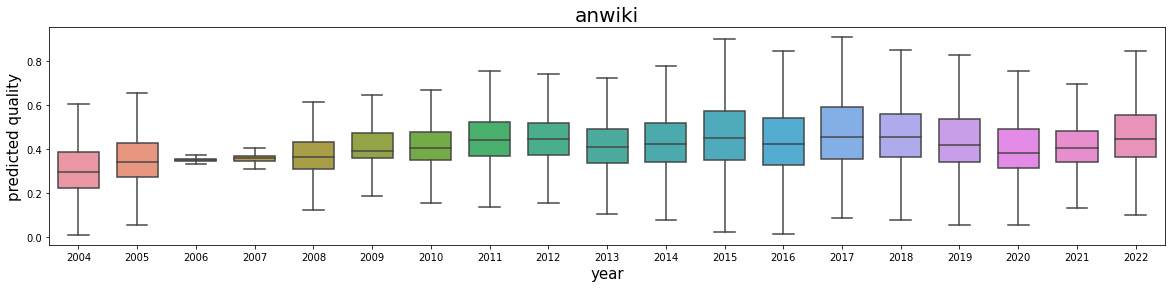

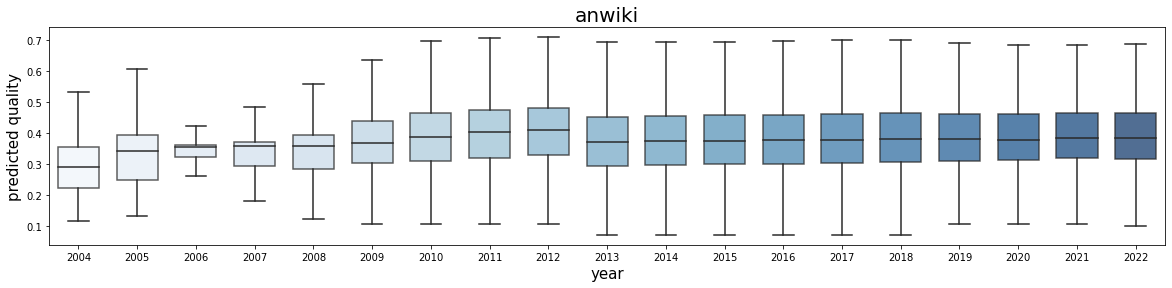

2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

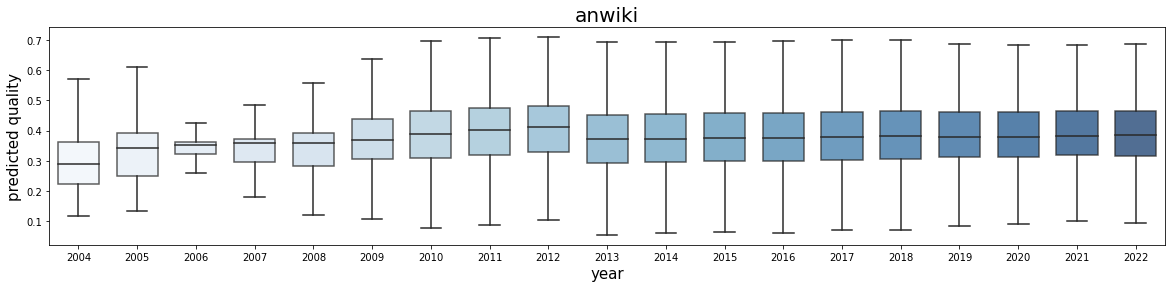

CPU times: user 8.09 s, sys: 1.27 s, total: 9.36 s
Wall time: 7min 5s


In [9]:
%%time
for wiki_db in ['anwiki']:
    print(datetime.datetime.now(), wiki_db)
    quality_scores_wiki = quality_scores.filter(quality_scores.wiki_db==wiki_db)
    quality_scores_wiki = quality_scores_wiki.withColumn('year', f.date_format('revision_timestamp', "yyyy").cast(IntegerType()))
    quality_scores_wiki.createOrReplaceTempView('scores_table_wiki')

    # Box plots of revisions in that year
    fig = plt.figure(figsize=(20, 4))
    df_boxplot = quality_scores_wiki.select(['year','pred_qual']).toPandas()
    sns.boxplot(x=df_boxplot["year"], y=df_boxplot["pred_qual"], width=0.7, showfliers = False)
    plt.title(wiki_db, fontsize=20)
    plt.xlabel('year', fontsize=15)
    plt.ylabel('predicted quality', fontsize=15)
    plt.show()
    
    # Box plots of the latests revisions of existing pages until that year
    last_revisions_union = spark.createDataFrame(data = spark.sparkContext.emptyRDD(), schema = StructType([]))
    last_revisions_union = last_revisions_union.withColumn('last_pred_qual', f.lit(0.0)).withColumn('year', f.lit(0))
    for i, year in enumerate(years[:-1]):
        last_revisions_union = last_revisions_union.union(spark.sql("""
            WITH last_revisions_of_pages AS (
                SELECT max(revision_id) max_revision_id
                FROM scores_table_wiki    
                WHERE to_timestamp(revision_timestamp)<to_timestamp('{next_year}-01')
                GROUP BY page_id
            )
            SELECT sta.pred_qual last_pred_qual
            FROM scores_table_wiki sta
            INNER JOIN last_revisions_of_pages lrop
            ON sta.revision_id = lrop.max_revision_id
        """.format(next_year=years[i+1])).withColumn('year', f.lit(year)))
    df_boxplot = last_revisions_union.toPandas()
    fig = plt.figure(figsize=(20, 4))
    ax = sns.boxplot(x=df_boxplot["year"], y=df_boxplot["last_pred_qual"], width=0.7, showfliers = False, palette='Blues', boxprops=dict(alpha=.75))
    plt.title(wiki_db, fontsize=20)
    plt.xlabel('year', fontsize=15)
    plt.ylabel('predicted quality', fontsize=15)
    plt.show()       
    
    # Box plots of the latests revisions of existing pages until that year using synthetic data
    df_boxplot = pd.DataFrame(columns=['wiki_db', 'min', 'q1', 'q2', 'q3', 'max', 'year'])
    for i, year in enumerate(years[:-1]):
        print (year, end=' ')
        yearly_median_quality_scores = spark.sql("""
            WITH last_revisions_of_pages AS (
                SELECT wiki_db, max(revision_id) max_revision_id
                FROM scores_table_wiki    
                WHERE to_timestamp(revision_timestamp)<to_timestamp('{next_year}-01')                
                GROUP BY wiki_db, page_id
            ),
            max_qualities AS (
                SELECT sta.wiki_db, sta.page_id, sta.pred_qual last_pred_qual
                FROM scores_table_wiki sta
                INNER JOIN last_revisions_of_pages lrop
                ON (sta.wiki_db = lrop.wiki_db AND sta.revision_id = lrop.max_revision_id)
            )
            SELECT
                wiki_db, 
                min(last_pred_qual) min,
                percentile_approx(last_pred_qual, 0.25) q1,
                percentile_approx(last_pred_qual, 0.50) q2,
                percentile_approx(last_pred_qual, 0.75) q3,
                max(last_pred_qual) max
            FROM max_qualities
            GROUP BY wiki_db
        """.format(next_year=years[i+1])).withColumn('year', f.lit(year))
        df_boxplot = pd.concat([df_boxplot,yearly_median_quality_scores.toPandas()])
        
    df_boxplot['iqr'] = df_boxplot['q3'] - df_boxplot['q1'] 
    df_boxplot['whisker_min'] = np.maximum(df_boxplot['q1']-1.499999*df_boxplot['iqr'],  df_boxplot['min'])
    df_boxplot['whisker_max'] = np.minimum(df_boxplot['q3']+1.499999*df_boxplot['iqr'],  df_boxplot['max'])

    df_boxplot_synthetic_values = pd.DataFrame(columns=['year', 'predicted quality'])
    for i, row in df_boxplot.iterrows():
        df_boxplot_synthetic_values_year = pd.DataFrame(columns=['year', 'predicted quality'])
        df_boxplot_synthetic_values_year['predicted quality'] = np.array([row.whisker_min, row.q1, row.q2, row.q3, row.whisker_max])
        df_boxplot_synthetic_values_year['year'] = row.year
        df_boxplot_synthetic_values = pd.concat([df_boxplot_synthetic_values, df_boxplot_synthetic_values_year])

    fig = plt.figure(figsize=(20, 4))
    ax = sns.boxplot(x=df_boxplot_synthetic_values["year"], y=df_boxplot_synthetic_values["predicted quality"], width=0.7, showfliers = False, palette='Blues', boxprops=dict(alpha=.75))
    plt.title(wiki_db, fontsize=20)
    plt.xlabel('year', fontsize=15)
    plt.ylabel('predicted quality', fontsize=15)
    plt.show()    

2023-01-31 21:24:07.786867 enwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

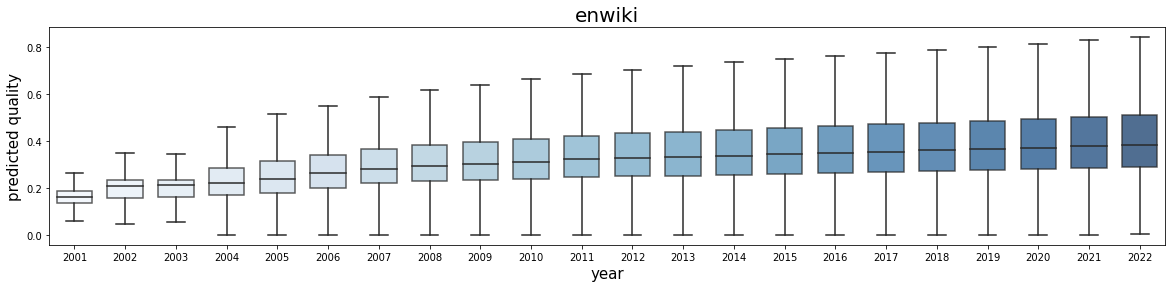

2023-01-31 21:45:42.065973 viwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

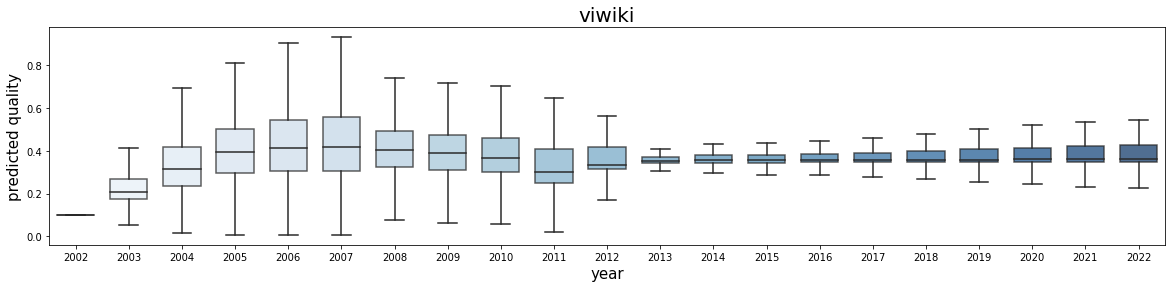

2023-01-31 21:51:26.959834 frwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

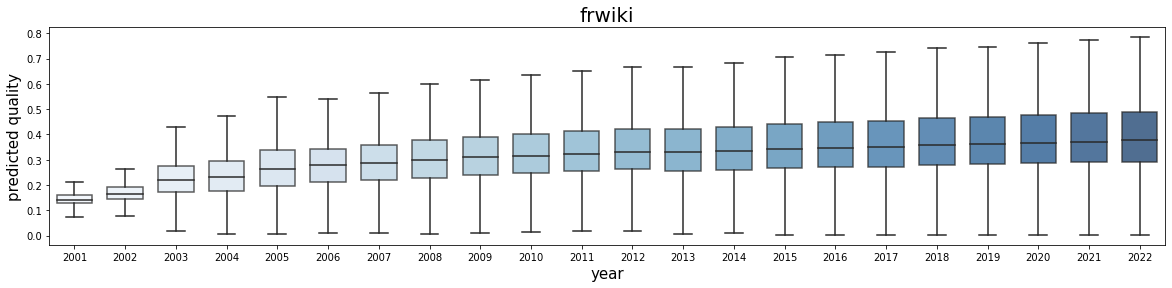

2023-01-31 22:12:26.948359 cebwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

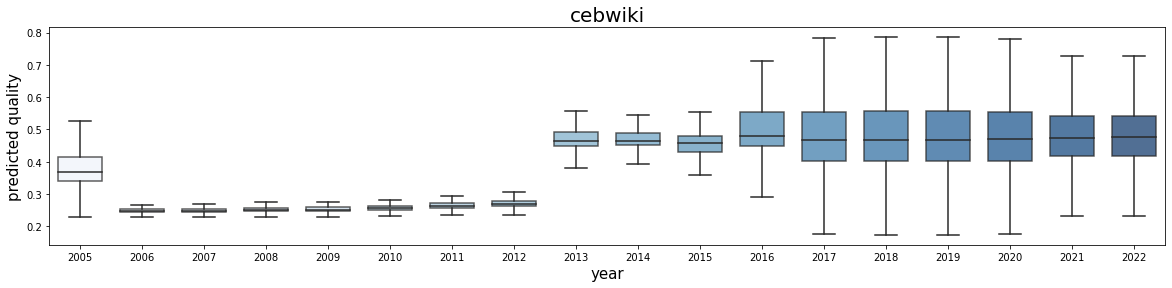

2023-01-31 22:16:36.409041 arwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

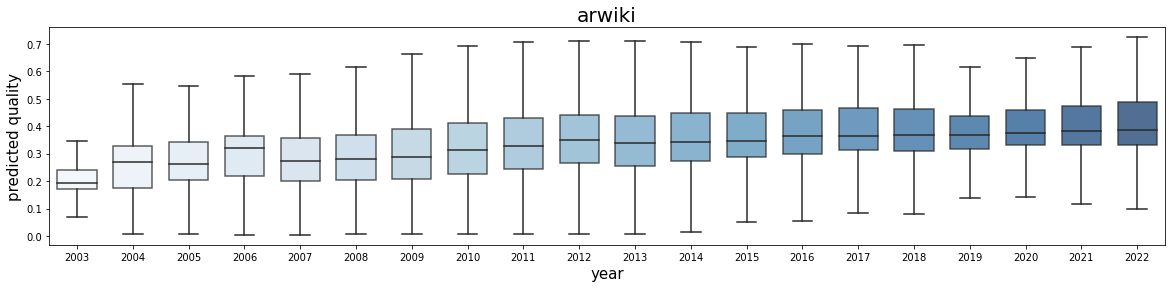

2023-01-31 22:20:42.125749 eswiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

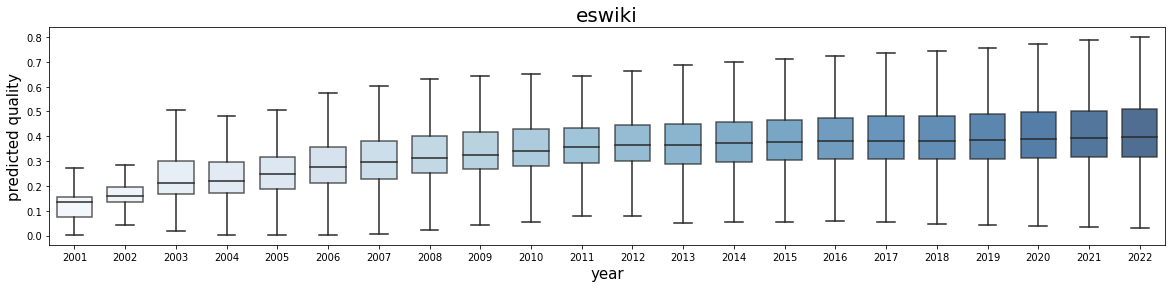

2023-01-31 22:25:19.100340 dewiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

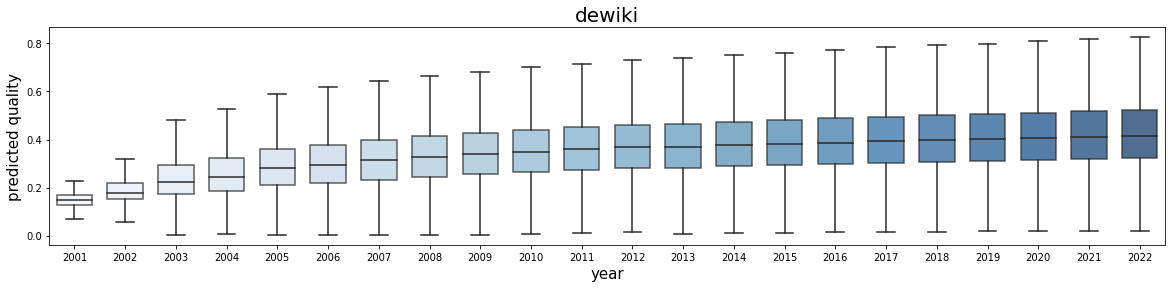

2023-01-31 22:30:08.715360 itwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

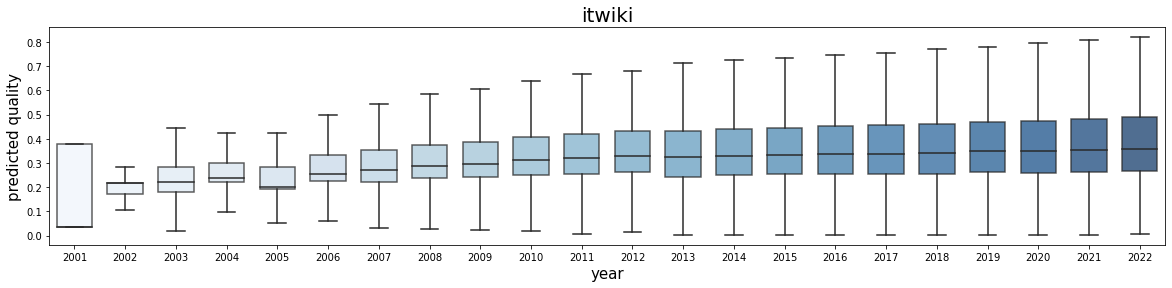

2023-01-31 22:33:55.840402 ruwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

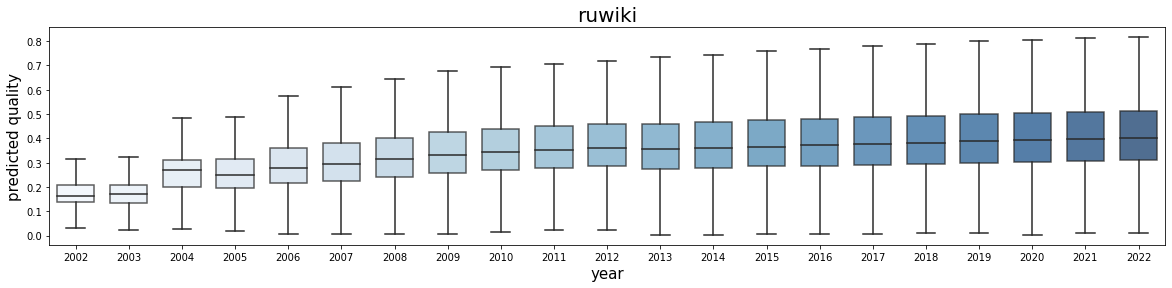

2023-01-31 22:37:29.832346 zhwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

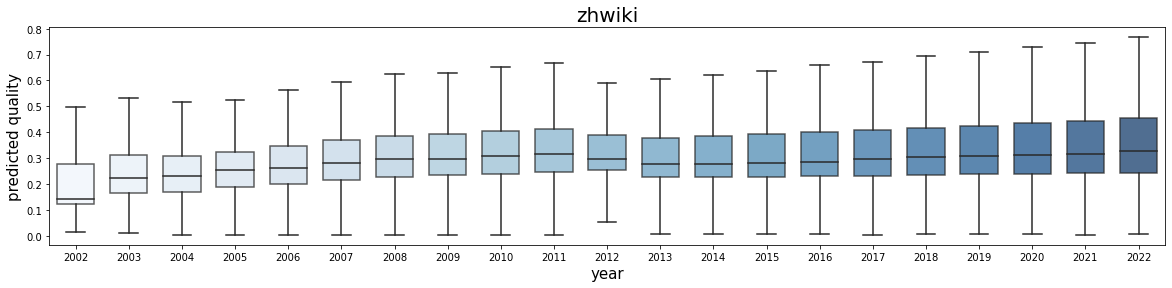

2023-01-31 22:41:56.019052 svwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

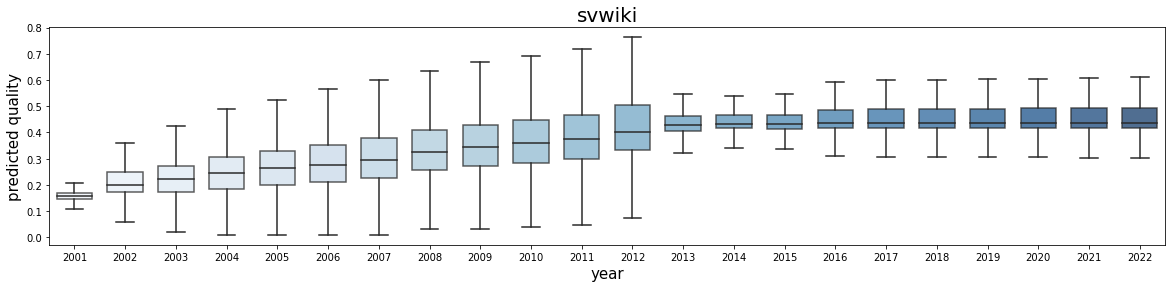

2023-01-31 22:45:49.041892 ptwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

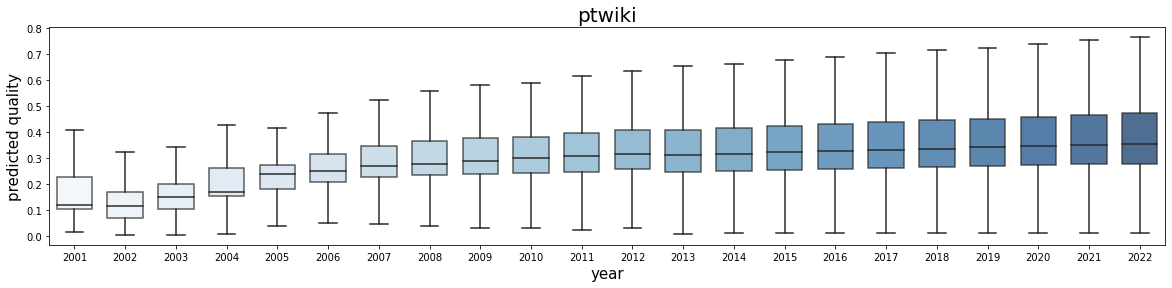

2023-01-31 22:49:27.969773 fawiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

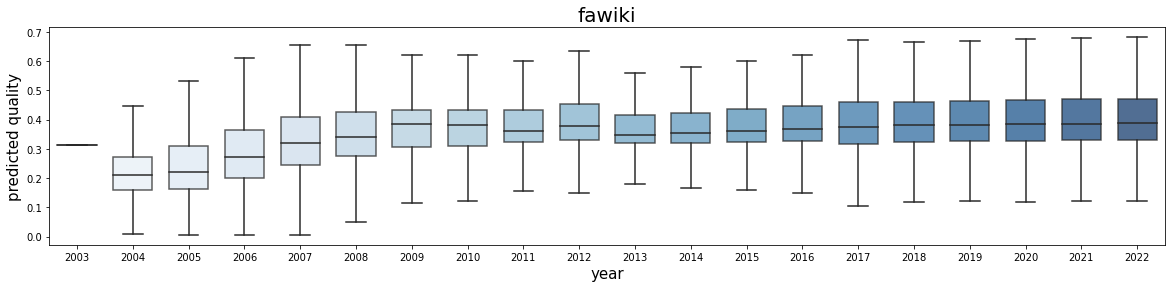

2023-01-31 22:53:07.951075 shwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

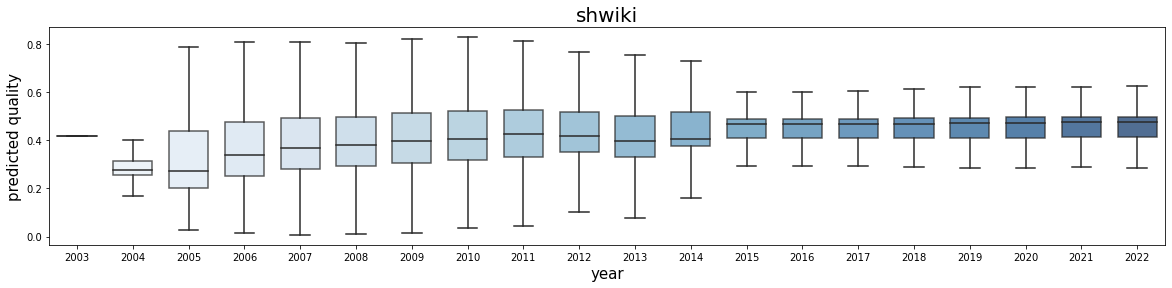

2023-01-31 22:56:24.591373 nlwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

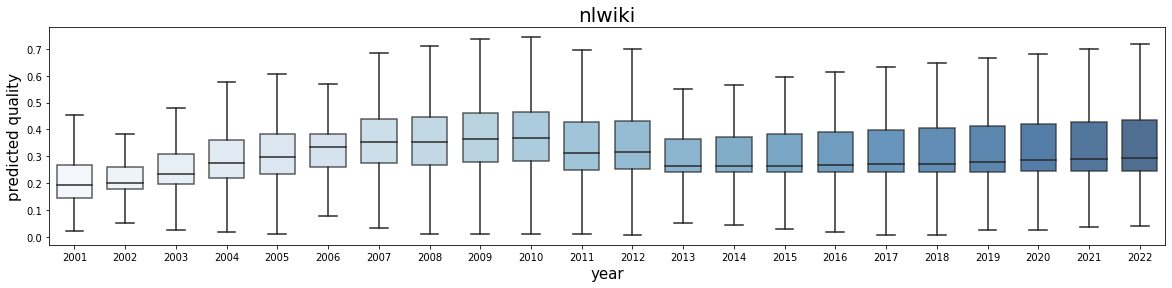

2023-01-31 22:59:55.252896 ukwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

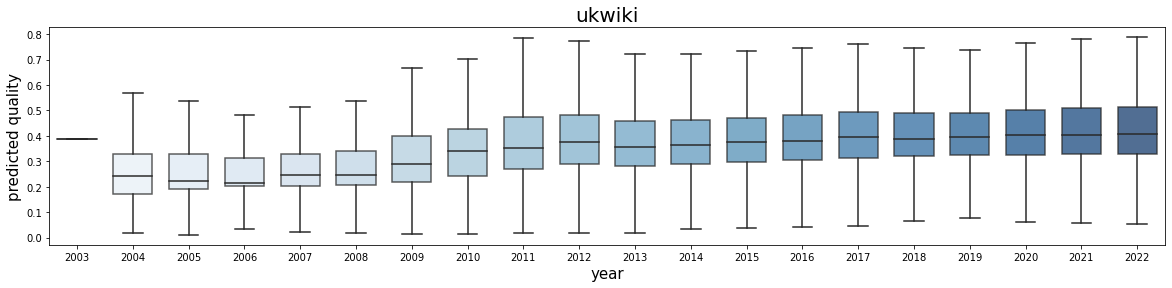

2023-01-31 23:03:15.079410 srwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

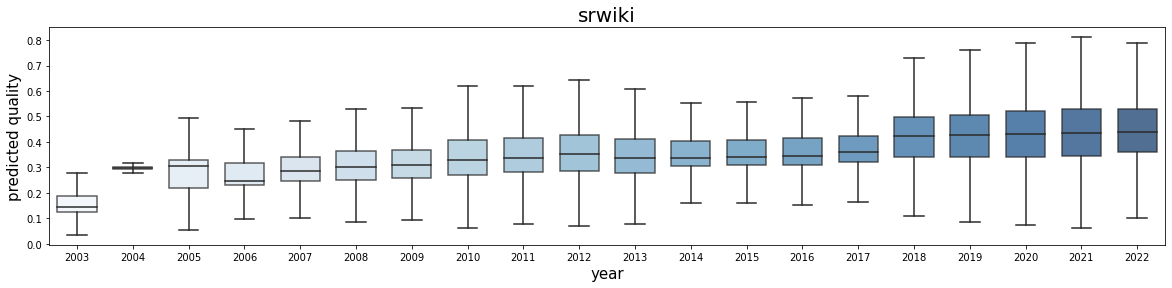

2023-01-31 23:06:40.194399 jawiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

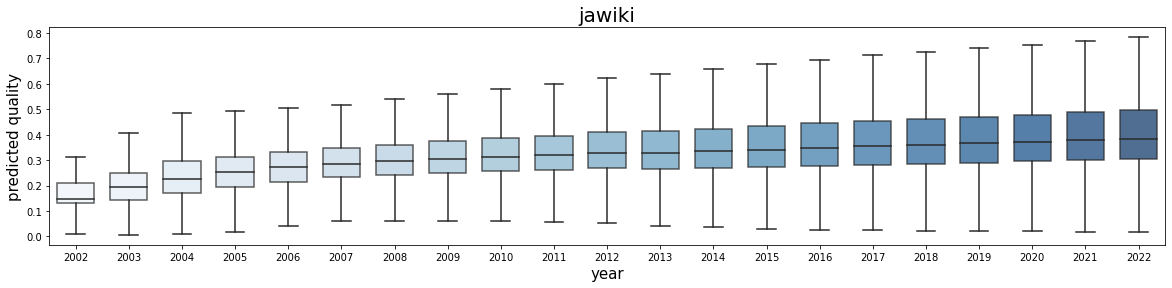

2023-01-31 23:10:18.611927 plwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

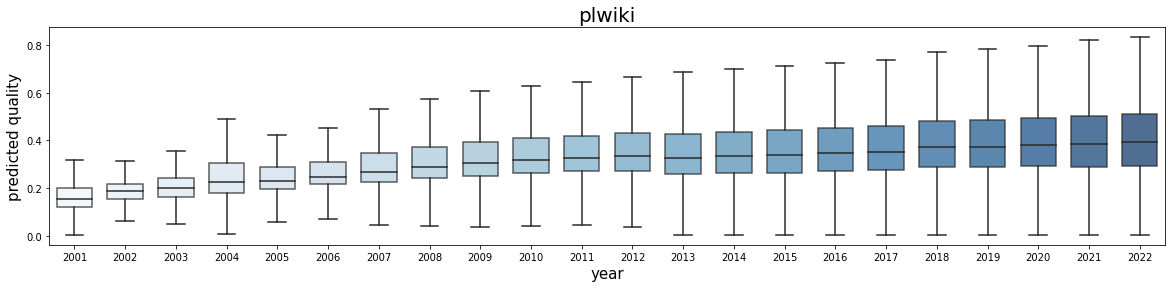

2023-01-31 23:13:53.108454 idwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

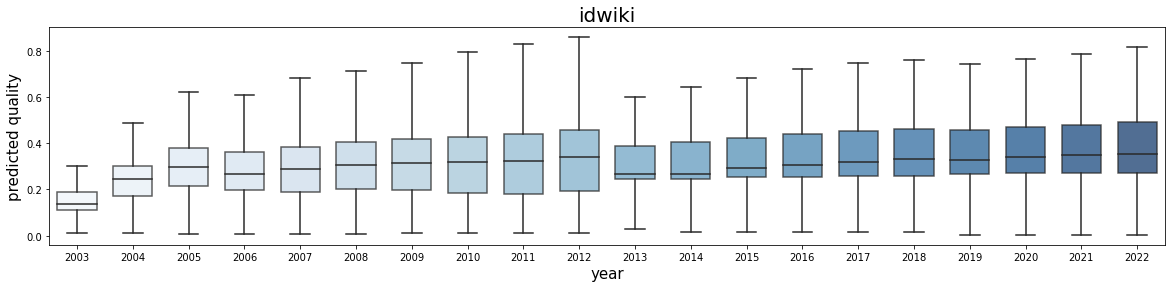

2023-01-31 23:17:56.877752 kowiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

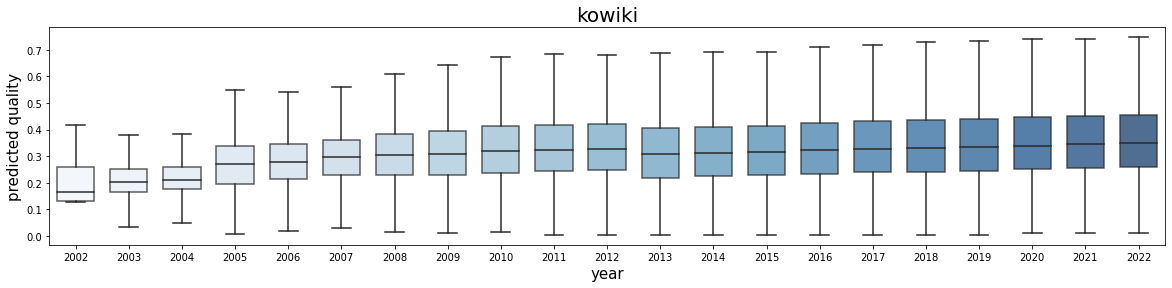

2023-01-31 23:21:19.814987 warwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

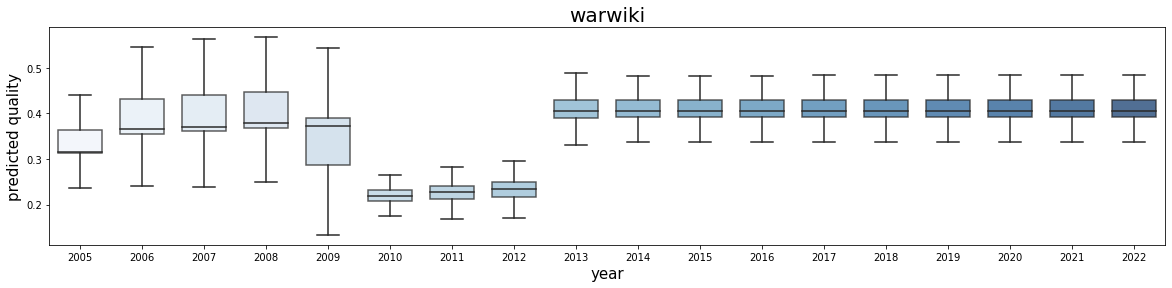

2023-01-31 23:24:42.583647 rowiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

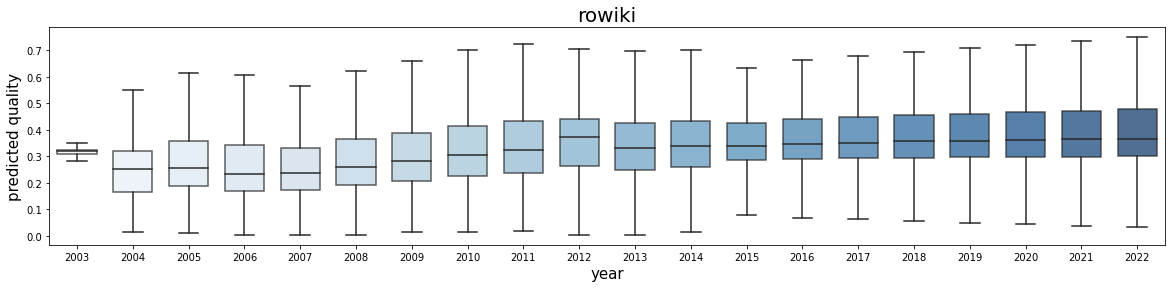

2023-01-31 23:28:11.723790 trwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

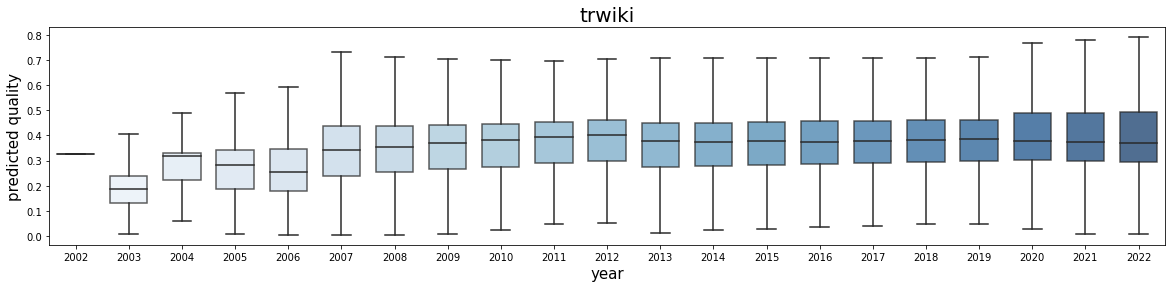

2023-01-31 23:31:23.478529 arzwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

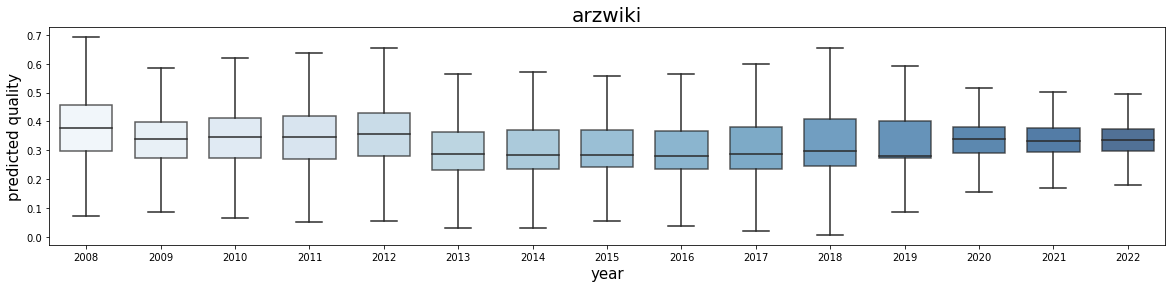

2023-01-31 23:35:07.658090 cawiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

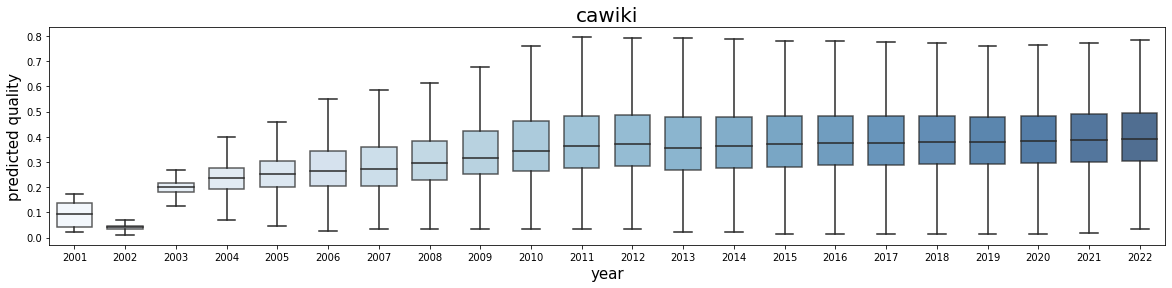

CPU times: user 36.7 s, sys: 5.74 s, total: 42.4 s
Wall time: 2h 14min 35s


In [10]:
%%time
for wiki_db in largest_wikis:
    print(datetime.datetime.now(), wiki_db)
    quality_scores_wiki = quality_scores.filter(quality_scores.wiki_db==wiki_db)
    quality_scores_wiki = quality_scores_wiki.withColumn('year', f.date_format('revision_timestamp', "yyyy").cast(IntegerType()))
    quality_scores_wiki.createOrReplaceTempView('scores_table_wiki')

    # Box plots of the latests revisions of existing pages until that year using synthetic data
    df_boxplot = pd.DataFrame(columns=['wiki_db', 'min', 'q1', 'q2', 'q3', 'max', 'year'])
    for i, year in enumerate(years[:-1]):
        print (year, end=' ')
        yearly_median_quality_scores = spark.sql("""
            WITH last_revisions_of_pages AS (
                SELECT wiki_db, max(revision_id) max_revision_id
                FROM scores_table_wiki    
                WHERE to_timestamp(revision_timestamp)<to_timestamp('{next_year}-01')                
                GROUP BY wiki_db, page_id
            ),
            max_qualities AS (
                SELECT sta.wiki_db, sta.page_id, sta.pred_qual last_pred_qual
                FROM scores_table_wiki sta
                INNER JOIN last_revisions_of_pages lrop
                ON (sta.wiki_db = lrop.wiki_db AND sta.revision_id = lrop.max_revision_id)
            )
            SELECT
                wiki_db, 
                min(last_pred_qual) min,
                percentile_approx(last_pred_qual, 0.25) q1,
                percentile_approx(last_pred_qual, 0.50) q2,
                percentile_approx(last_pred_qual, 0.75) q3,
                max(last_pred_qual) max
            FROM max_qualities
            GROUP BY wiki_db
        """.format(next_year=years[i+1])).withColumn('year', f.lit(year))
        df_boxplot = pd.concat([df_boxplot,yearly_median_quality_scores.toPandas()])
        
    df_boxplot['iqr'] = df_boxplot['q3'] - df_boxplot['q1'] 
    df_boxplot['whisker_min'] = np.maximum(df_boxplot['q1']-1.499999*df_boxplot['iqr'],  df_boxplot['min'])
    df_boxplot['whisker_max'] = np.minimum(df_boxplot['q3']+1.499999*df_boxplot['iqr'],  df_boxplot['max'])
    df_boxplot.to_csv('figures/{wiki_db}_cuartiles.csv'.format(wiki_db=wiki_db), index=False)

    df_boxplot_synthetic_values = pd.DataFrame(columns=['year', 'predicted quality'])
    for i, row in df_boxplot.iterrows():
        df_boxplot_synthetic_values_year = pd.DataFrame(columns=['year', 'predicted quality'])
        df_boxplot_synthetic_values_year['predicted quality'] = np.array([row.whisker_min, row.q1, row.q2, row.q3, row.whisker_max])
        df_boxplot_synthetic_values_year['year'] = row.year
        df_boxplot_synthetic_values = pd.concat([df_boxplot_synthetic_values, df_boxplot_synthetic_values_year])

    fig = plt.figure(figsize=(20, 4))
    ax = sns.boxplot(x=df_boxplot_synthetic_values["year"], y=df_boxplot_synthetic_values["predicted quality"], width=0.7, showfliers = False, palette='Blues', boxprops=dict(alpha=.75))
    plt.title(wiki_db, fontsize=20)
    plt.xlabel('year', fontsize=15)
    plt.ylabel('predicted quality', fontsize=15)
    plt.savefig('figures/{wiki_db}_boxplot.pdf'.format(wiki_db=wiki_db), format="pdf", bbox_inches="tight")
    plt.savefig('figures/{wiki_db}_boxplot.png'.format(wiki_db=wiki_db), format="png", bbox_inches="tight")
    plt.show()    

2023-02-01 04:05:37.968113 hewiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

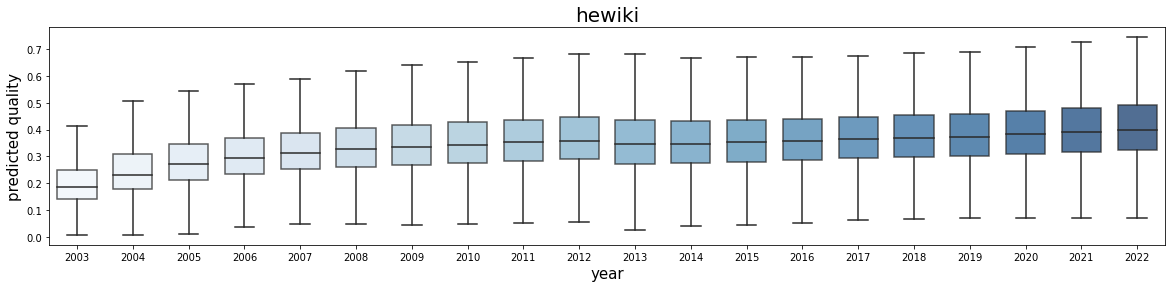

2023-02-01 04:12:03.728661 huwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

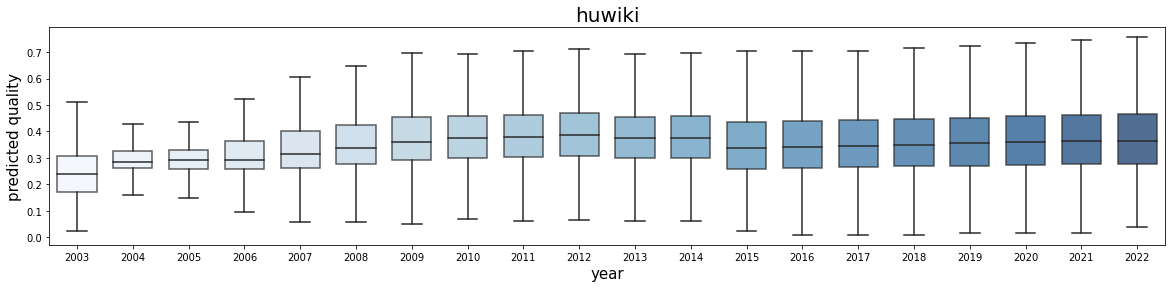

2023-02-01 04:17:30.140331 nowiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

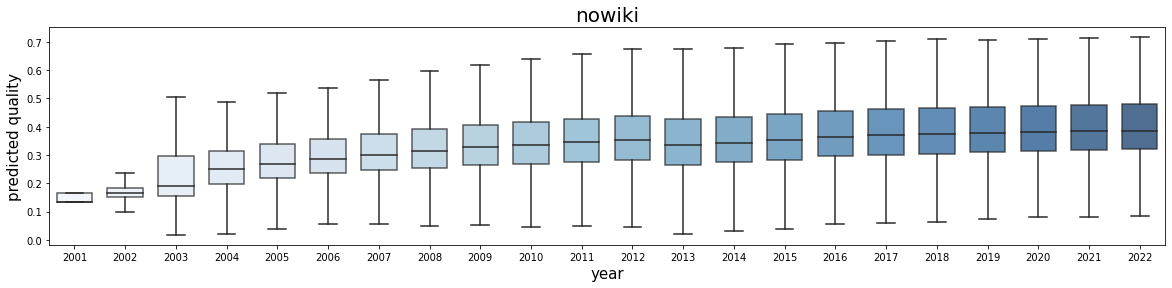

2023-02-01 04:29:48.574134 cswiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

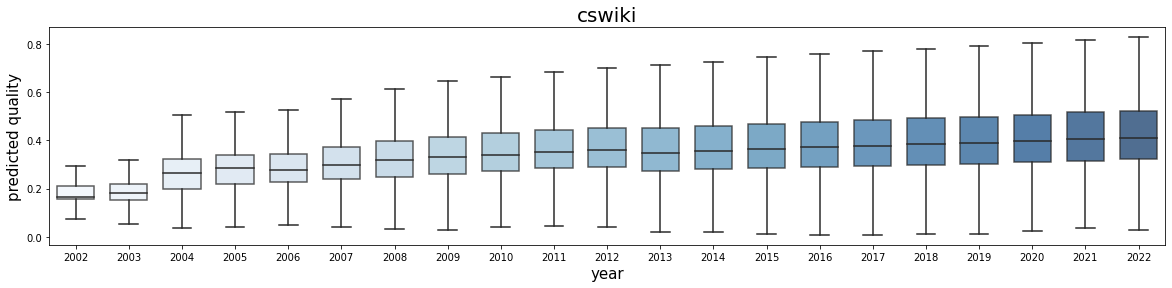

2023-02-01 04:37:34.652383 fiwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

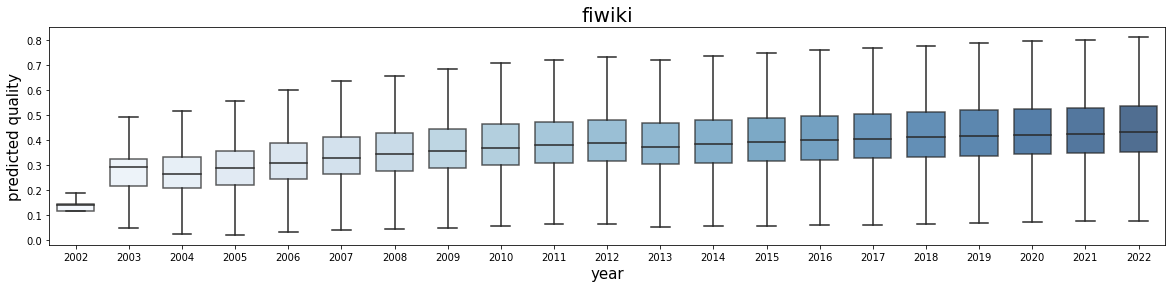

2023-02-01 04:44:21.944886 cywiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

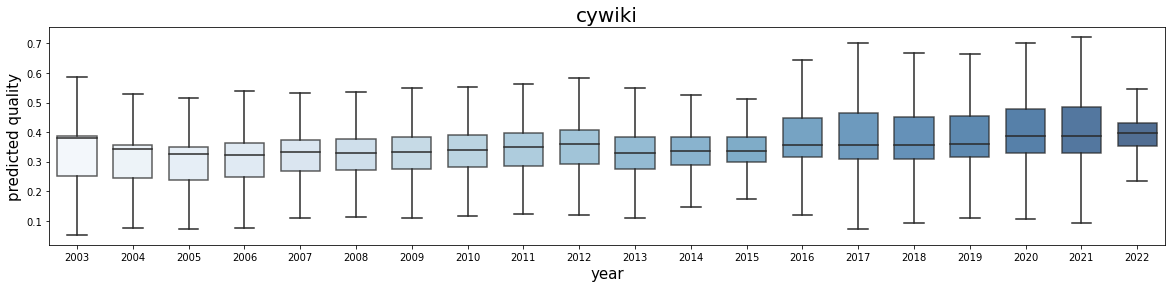

2023-02-01 04:50:07.504716 bgwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

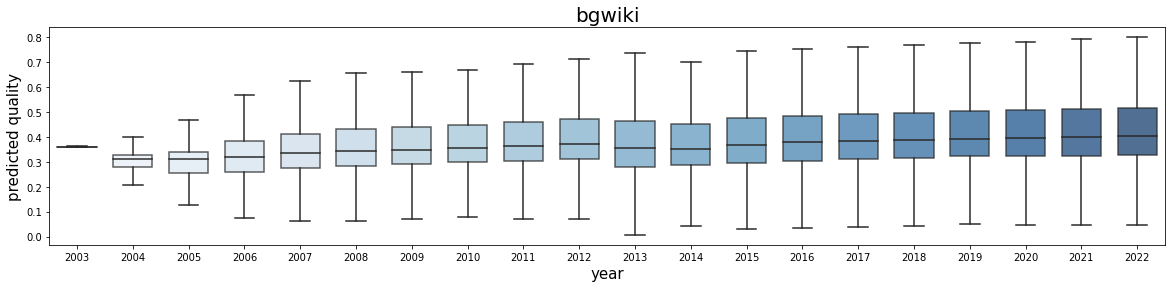

2023-02-01 04:56:19.829932 dawiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

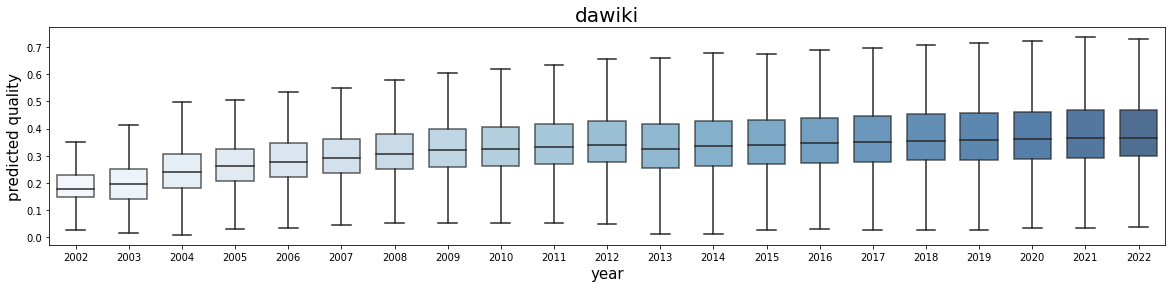

2023-02-01 05:02:18.222456 cewiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

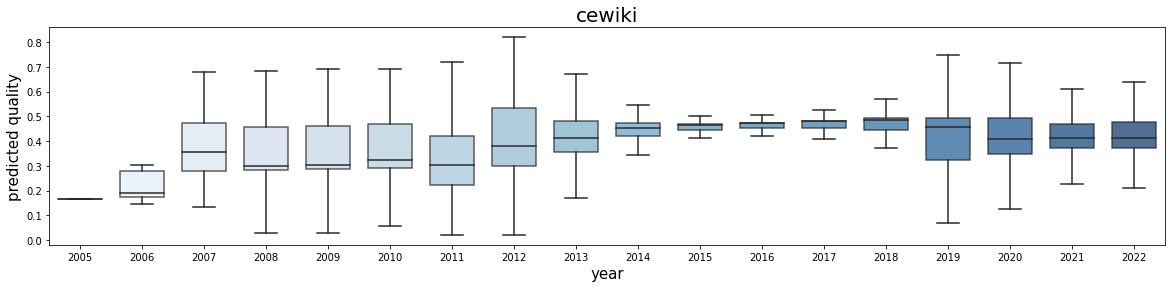

2023-02-01 05:08:19.573478 elwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

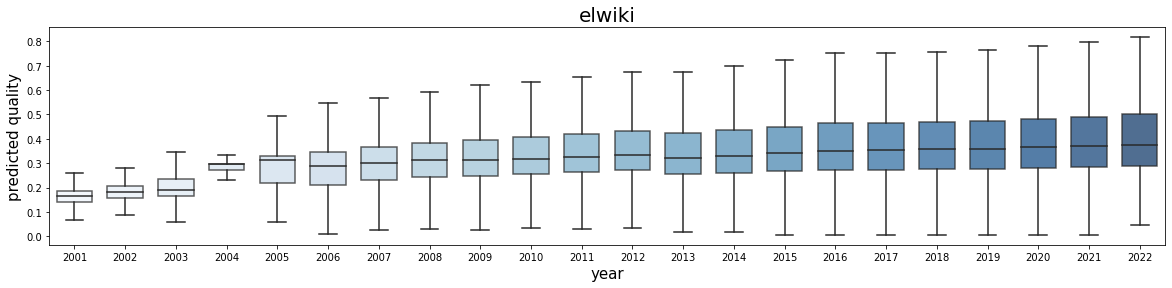

2023-02-01 05:14:25.521281 thwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

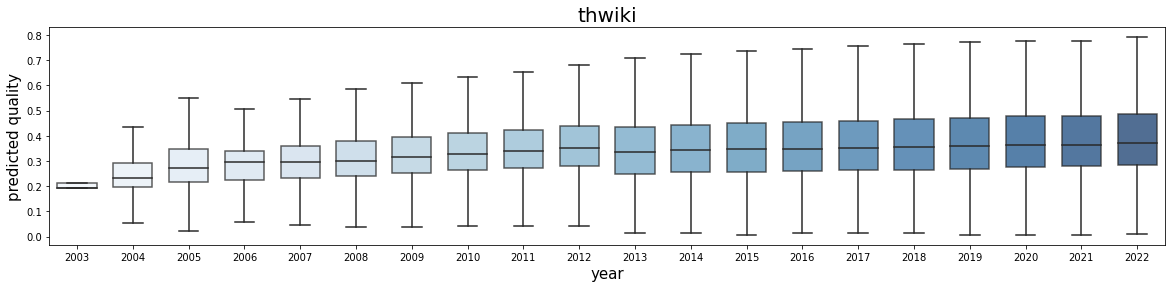

2023-02-01 05:21:11.079663 euwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

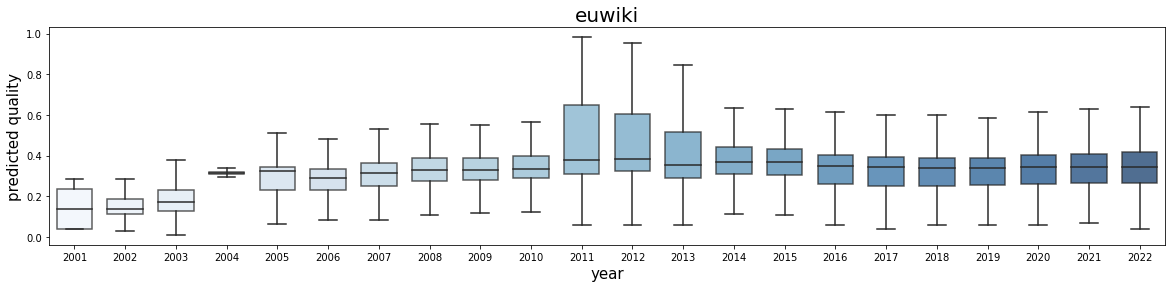

2023-02-01 05:27:55.530558 eowiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

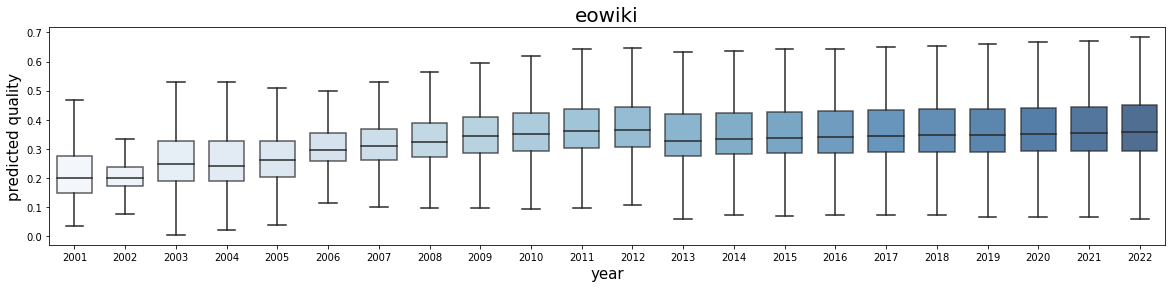

2023-02-01 05:33:29.625407 hywiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

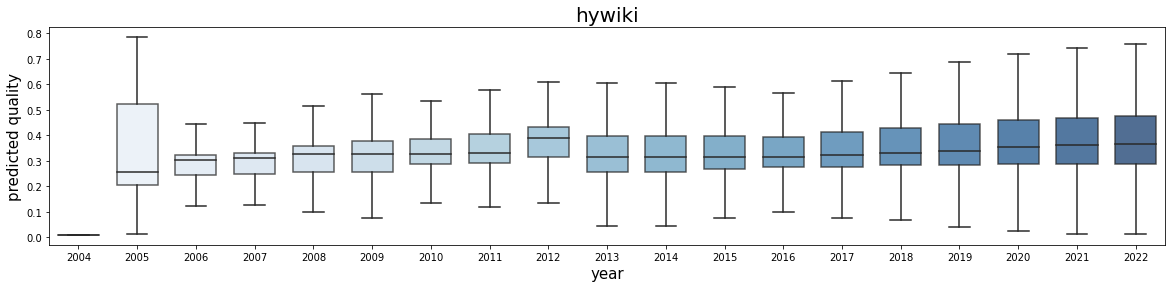

2023-02-01 05:38:08.006251 skwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

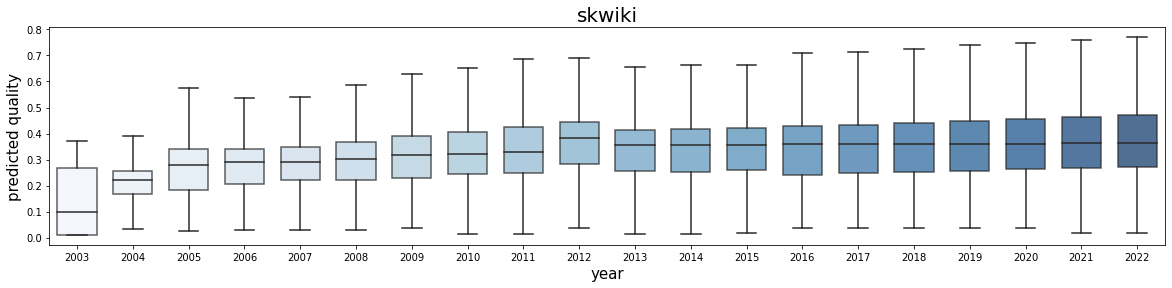

2023-02-01 05:42:51.232192 simplewiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

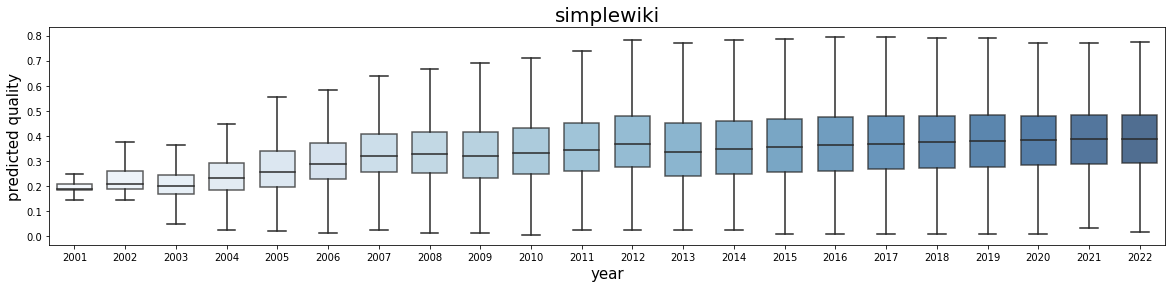

2023-02-01 05:47:32.969322 ltwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

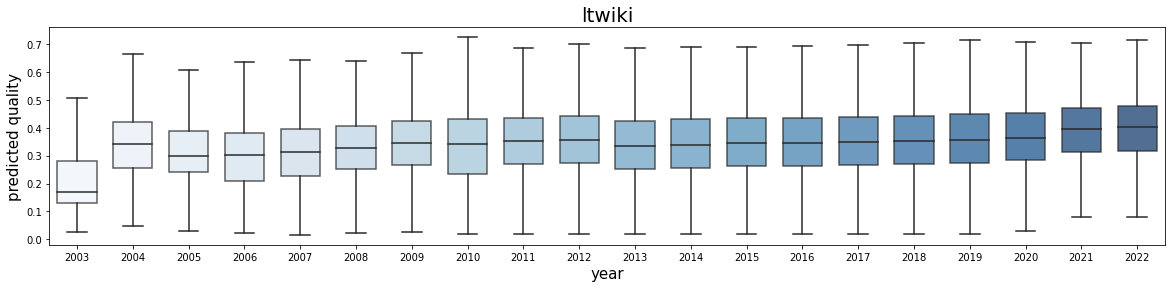

2023-02-01 05:52:13.522883 glwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

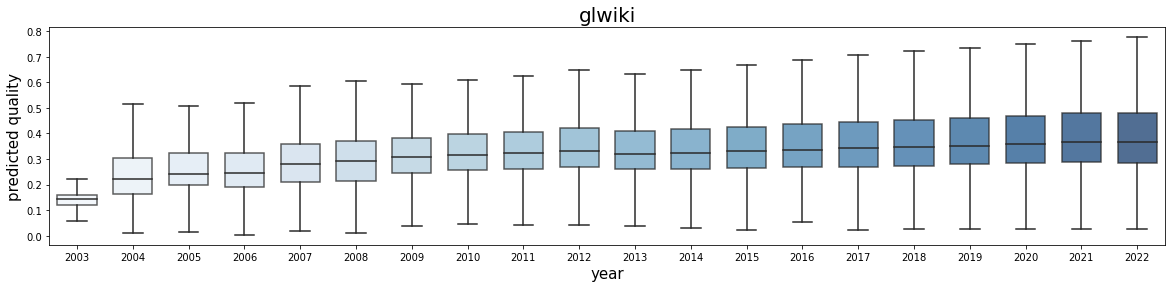

2023-02-01 05:56:56.826146 etwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

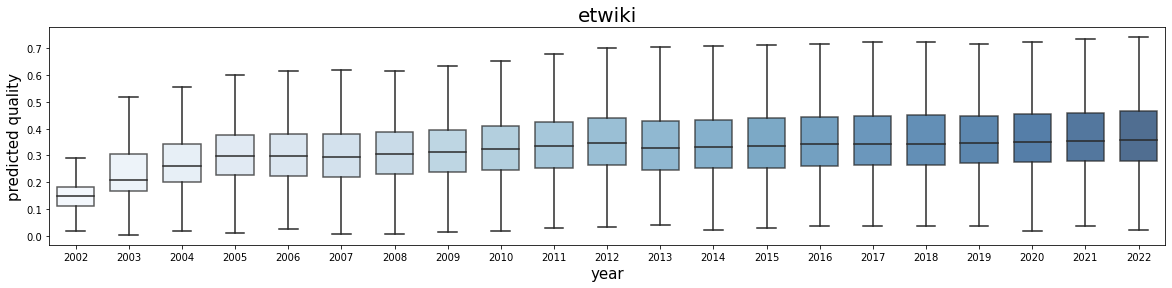

2023-02-01 06:02:11.565579 hrwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

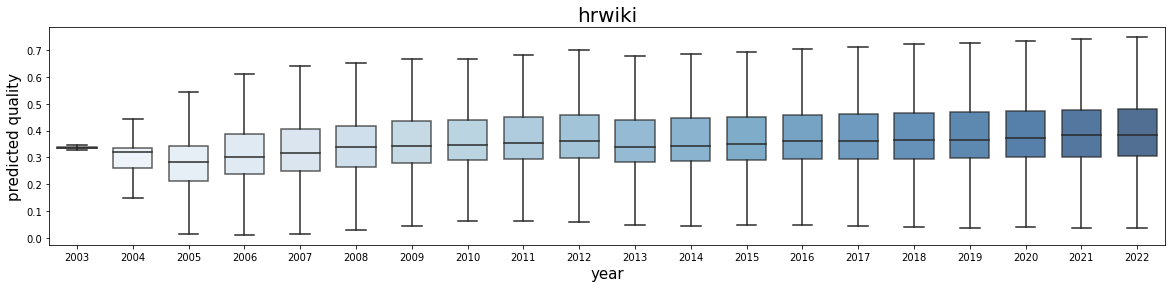

2023-02-01 06:06:55.292523 azwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

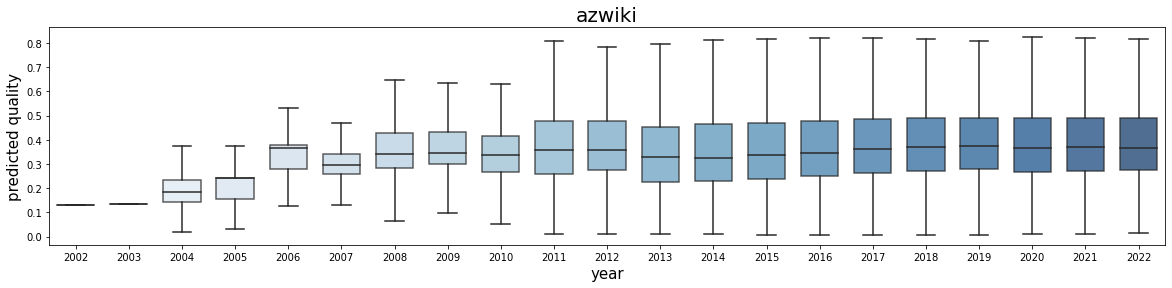

2023-02-01 06:12:13.517999 slwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

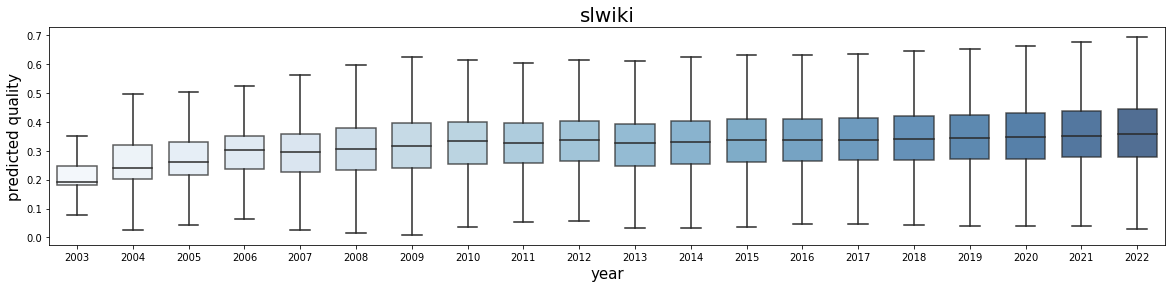

2023-02-01 06:17:25.824313 mswiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

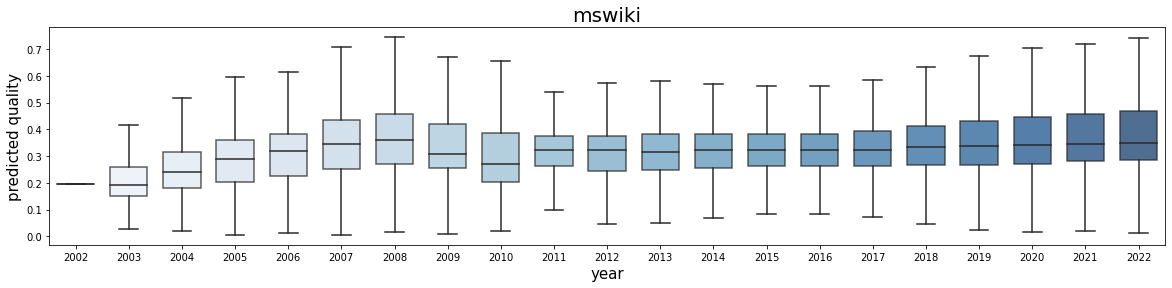

2023-02-01 06:22:30.555088 bnwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

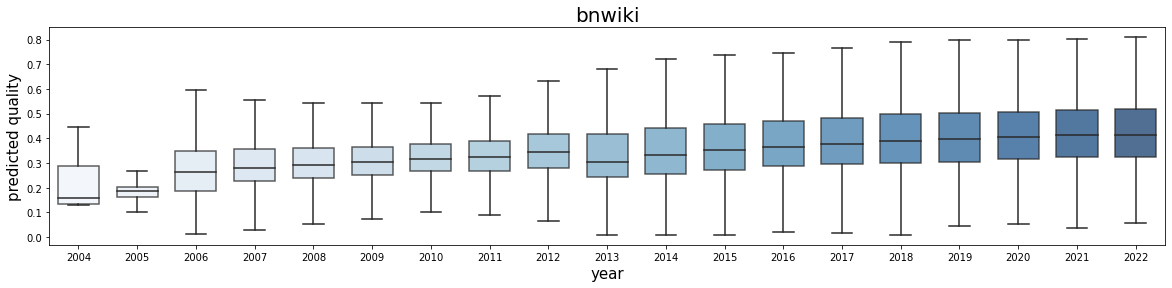

2023-02-01 06:28:38.845322 astwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

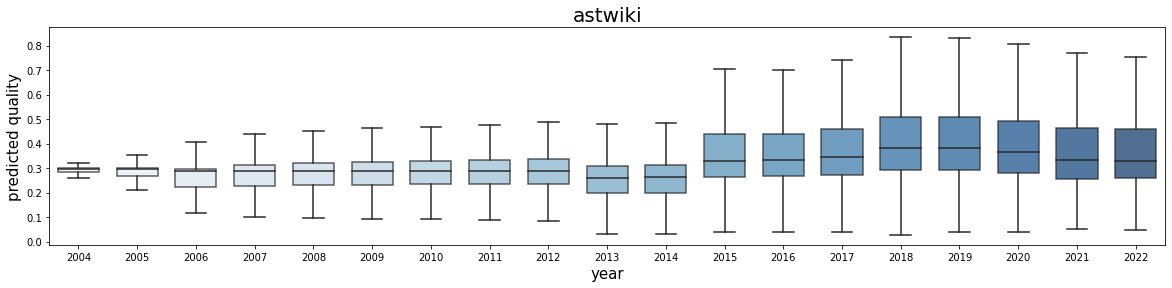

2023-02-01 06:33:50.829724 hiwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

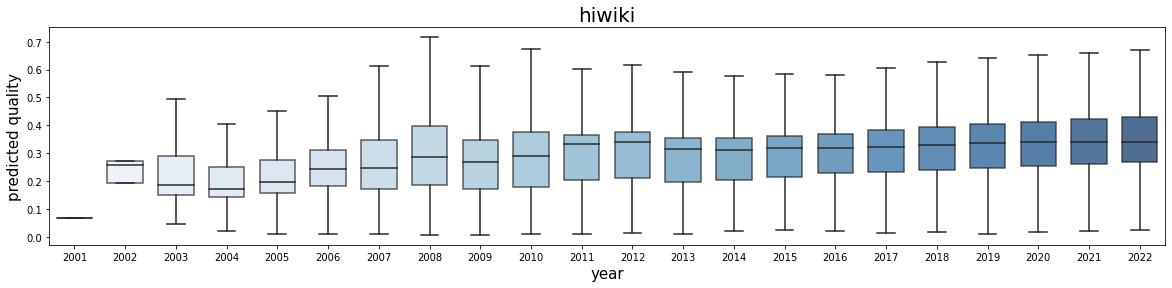

2023-02-01 06:38:30.037639 ttwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

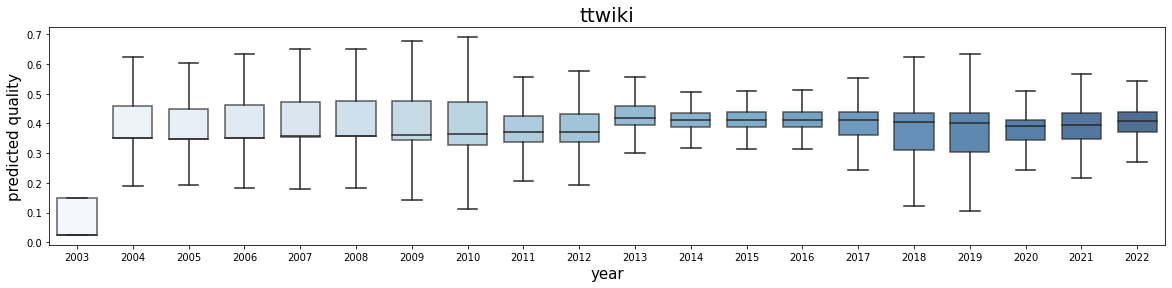

2023-02-01 06:43:01.380811 urwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

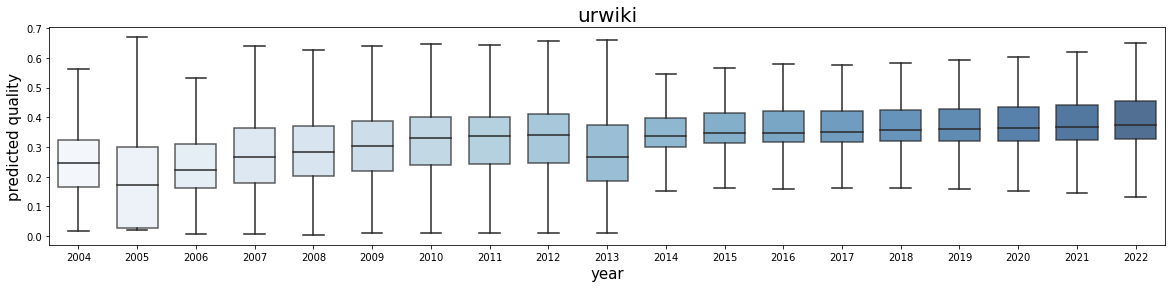

2023-02-01 06:47:36.227148 kawiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

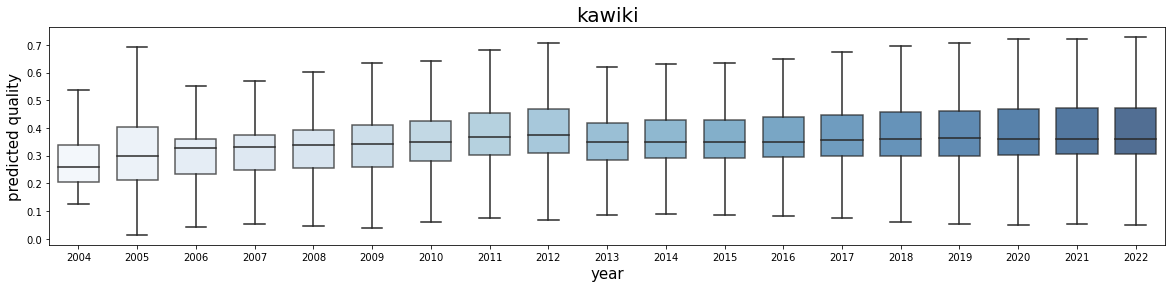

2023-02-01 06:52:18.422014 bewiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

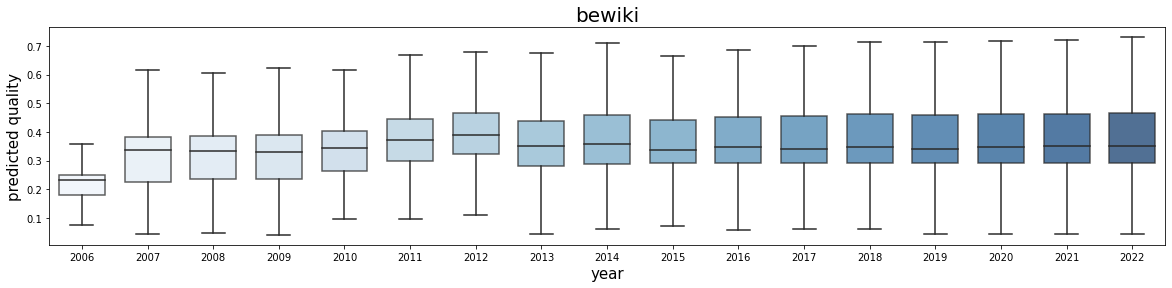

2023-02-01 06:57:31.464539 lawiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

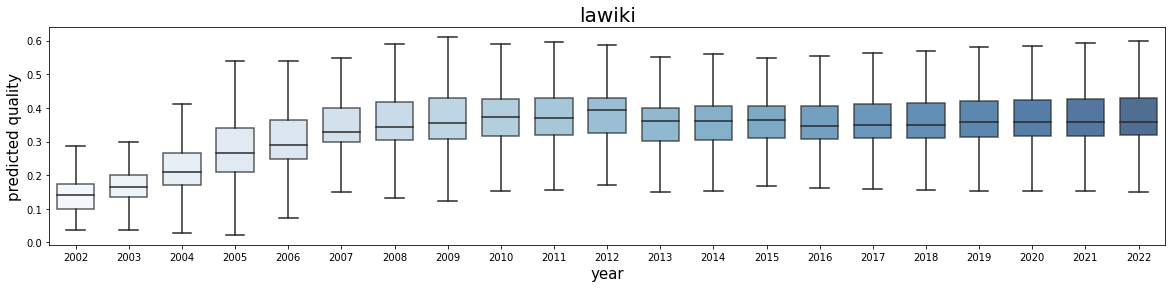

2023-02-01 07:02:32.305755 mkwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

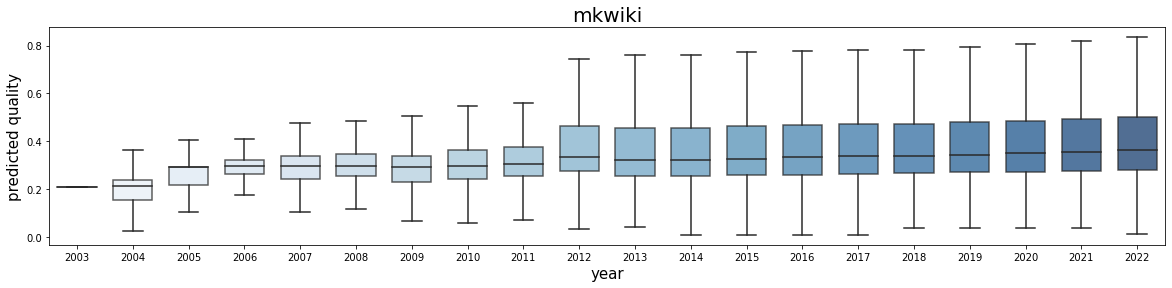

2023-02-01 07:07:09.357238 lvwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

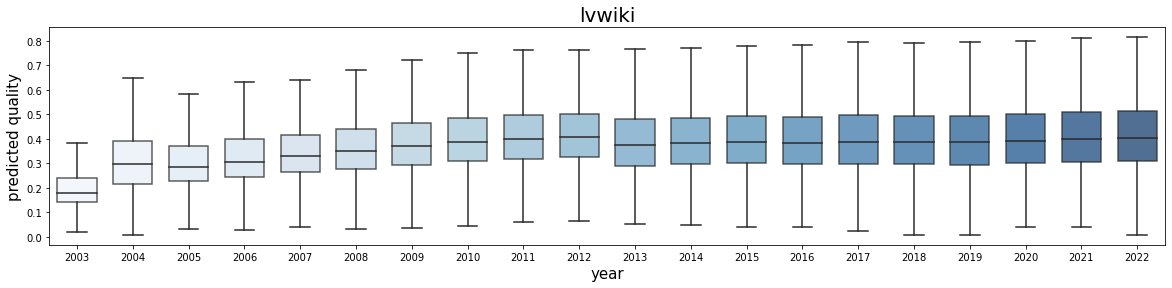

2023-02-01 07:11:46.856267 tewiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

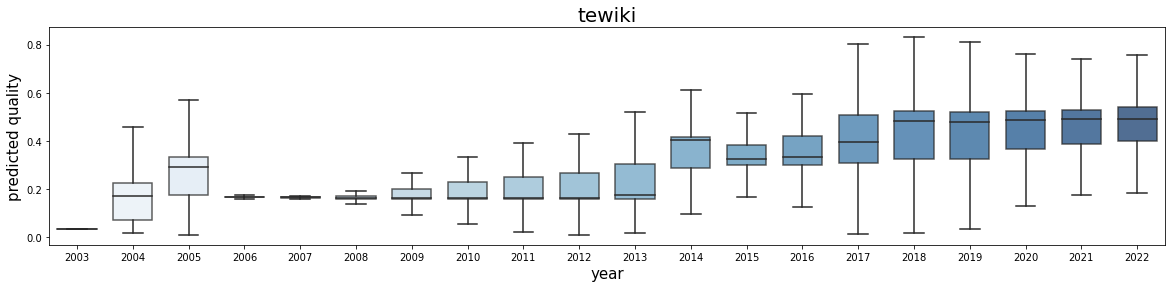

2023-02-01 07:16:50.995182 nnwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

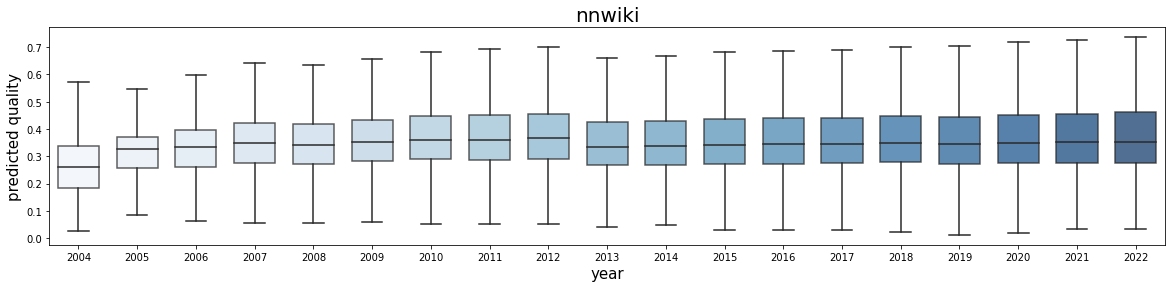

2023-02-01 07:22:47.826033 tawiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

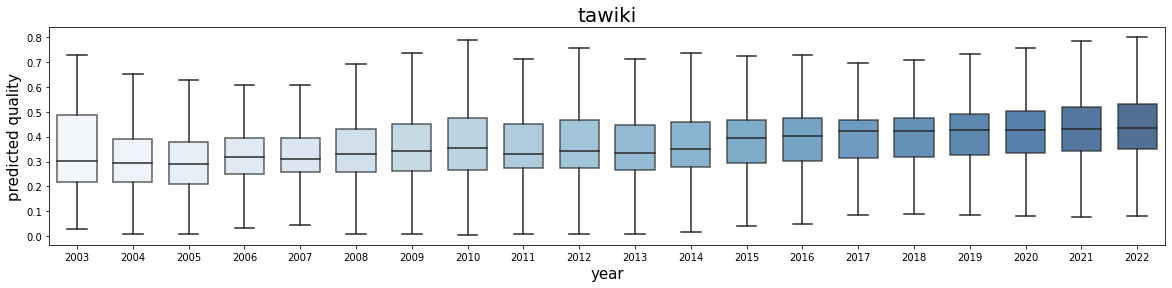

2023-02-01 07:27:54.775895 minwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

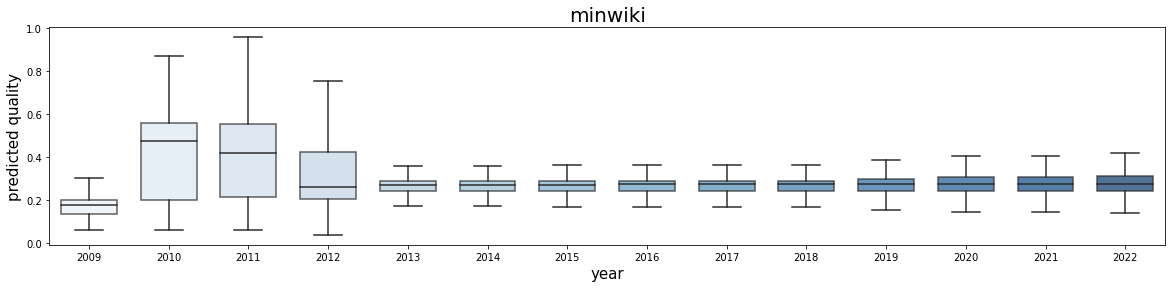

2023-02-01 07:32:50.544630 uzwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

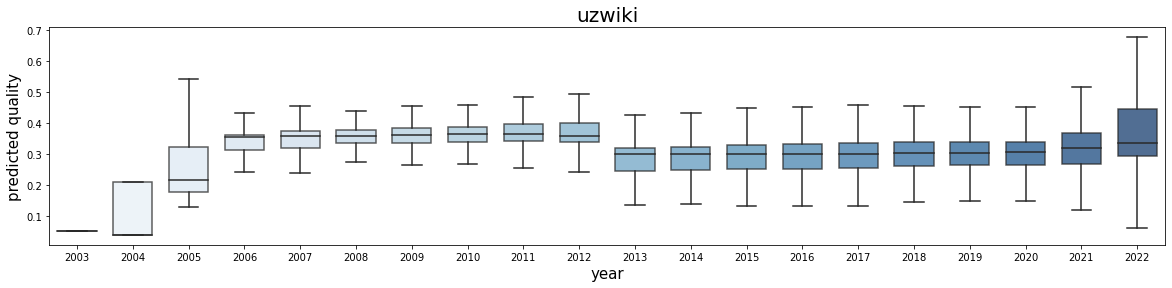

2023-02-01 07:37:28.349404 zh_min_nanwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

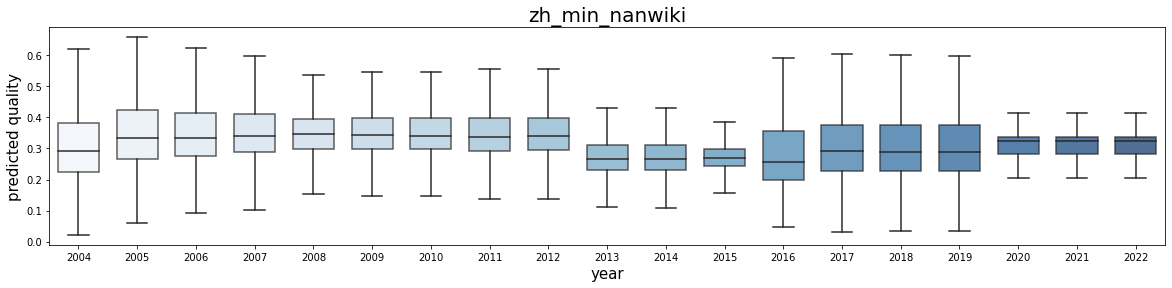

2023-02-01 07:42:41.859011 kkwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

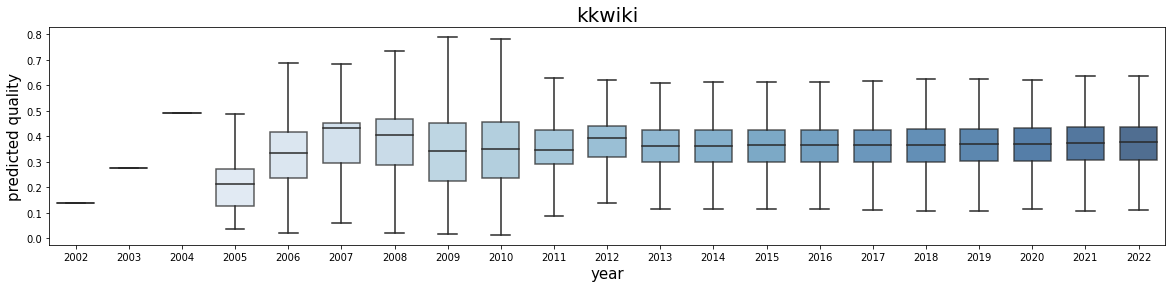

2023-02-01 07:47:13.849520 bswiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

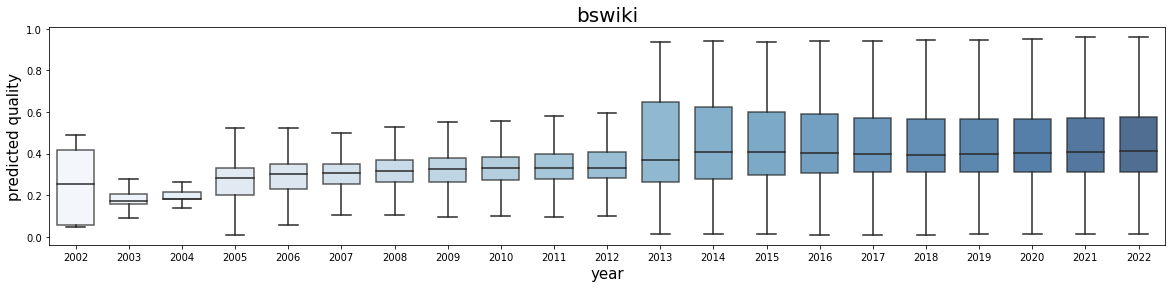

2023-02-01 07:52:22.770814 afwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

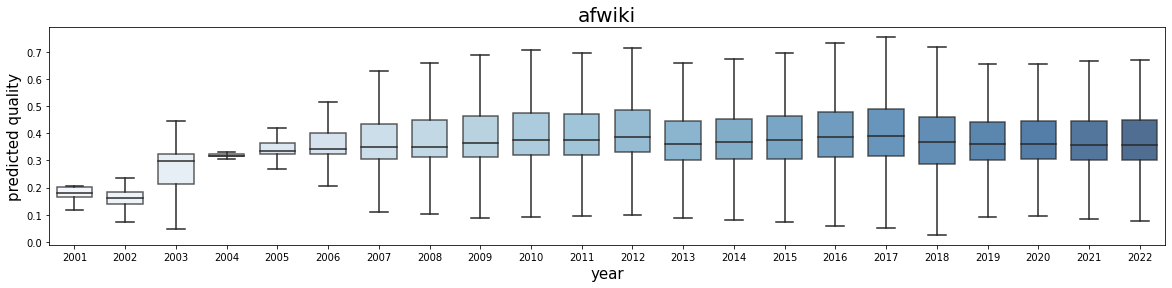

2023-02-01 07:57:26.332265 lbwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

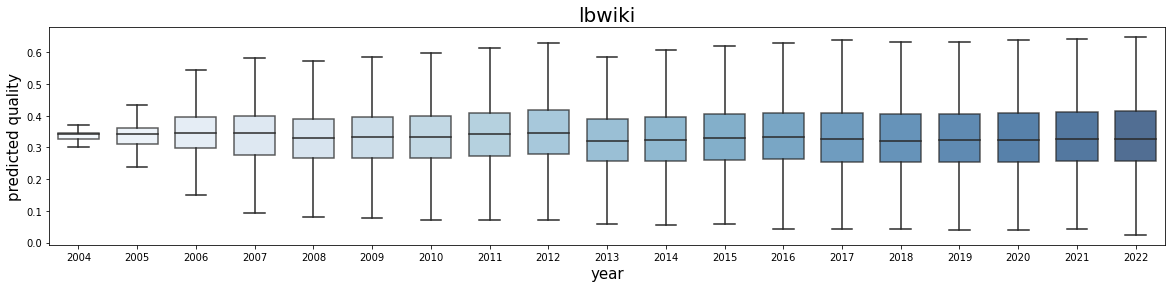

2023-02-01 08:01:58.098479 mlwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

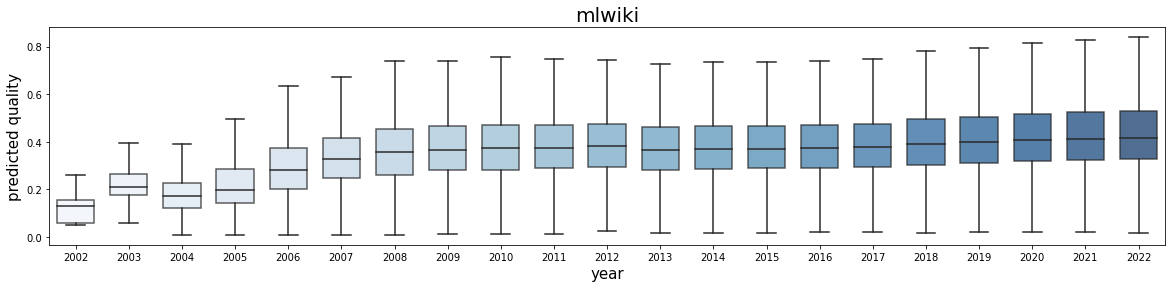

2023-02-01 08:06:21.551385 sqwiki
2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

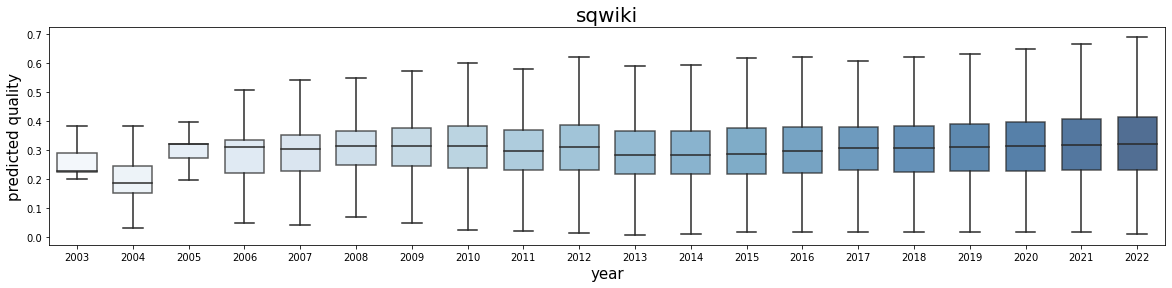

2023-02-01 08:10:42.383763 ocwiki
2001 2002 

In [ ]:
%%time
other_wikis = ['hewiki',  'huwiki',  'nowiki',  'cswiki',  'fiwiki',  'cywiki',  'bgwiki',  'dawiki',  'cewiki',  'elwiki',  'thwiki',  'euwiki',  'eowiki',  
               'hywiki',  'skwiki',  'simplewiki',  'ltwiki',  'glwiki',  'etwiki',  'hrwiki',  'azwiki',  'slwiki',  'mswiki',  'bnwiki',  'astwiki',  'hiwiki',  
               'ttwiki',  'urwiki',  'kawiki',  'bewiki',  'lawiki',  'mkwiki',  'lvwiki',  'tewiki',  'nnwiki',  'tawiki',  'minwiki',  'uzwiki',  'zh_min_nanwiki', 
               'kkwiki',  'bswiki',  'afwiki',  'lbwiki',  'mlwiki',  'sqwiki',  'ocwiki',  'brwiki',  'mrwiki',  'be_x_oldwiki',  'anwiki',  'zh_yuewiki',  'iswiki',  
               'jvwiki',  'tlwiki',  'tgwiki',  'azbwiki',  'gawiki',  'swwiki',  'vecwiki',  'kuwiki',  'fywiki',  'bawiki',  'iowiki',  'ndswiki',  'pmswiki',  'htwiki',
               'mgwiki',  'alswiki',  'lmowiki',  'vowiki',  'cvwiki',  'scnwiki',  'knwiki',  'newiki',  'bpywiki',  'mywiki',  'ckbwiki',  'napwiki',  'pnbwiki',  'guwiki',
               'suwiki',  'iawiki',  'gdwiki',  'scowiki',  'quwiki',  'mnwiki',  'pawiki',  'barwiki',  'newwiki',  'yiwiki',  'yowiki',  'liwiki',  'oswiki',  'siwiki',  
               'kywiki',  'sawiki',  'diqwiki',  'amwiki',  'bat_smgwiki',  'fowiki',  'nahwiki',  'sahwiki',  'wawiki',  'orwiki',  'pamwiki',  'ilowiki',  'szlwiki',  'hsbwiki',
               'nds_nlwiki',  'vlswiki',  'sewiki',  'nrmwiki',  'nvwiki',  'cowiki',  'bclwiki',  'zh_classicalwiki',  'lijwiki',  'aswiki',  'bugwiki',  'tkwiki',  'wuuwiki',
               'gvwiki',  'hywwiki',  'frpwiki',  'pswiki',  'ganwiki',  'frrwiki',  'sowiki',  'kwwiki',  'map_bmswiki',  'mtwiki',  'hawiki',  'kmwiki',  'csbwiki',  'hifwiki',
               'furwiki',  'xmfwiki',  'fiu_vrowiki',  'gomwiki',  'mhrwiki',  'arywiki',  'szywiki',  'sdwiki',  'scwiki',  'iewiki',  'miwiki',  'crhwiki',  'avkwiki',  'kshwiki',
               'angwiki',  'ladwiki',  'lldwiki',  'ugwiki',  'roa_tarawiki',  'mznwiki',  'rmwiki',  'ruewiki',  'emlwiki',  'dvwiki',  'acewiki',  'banwiki',  'bowiki',  'vepwiki',
               'stqwiki',  'kvwiki',  'zeawiki',  'piwiki',  'hakwiki',  'extwiki',  'lnwiki',  'gnwiki',  'myvwiki',  'nostalgiawiki',  'satwiki',  'bhwiki',  'novwiki',  'mrjwiki',
               'jbowiki',  'udmwiki',  'arcwiki',  'igwiki',  'dsbwiki',  'papwiki',  'snwiki',  'hawwiki',  'wowiki',  'pdcwiki',  'maiwiki',  'kabwiki',  'xalwiki',  'aywiki', 
               'pflwiki',  'cdowiki',  'krcwiki',  'lowiki',  'pagwiki',  'mwlwiki',  'rwwiki',  'abwiki',  'test2wiki',  'pcdwiki',  'lezwiki',  'cbk_zamwiki',  'bjnwiki',  
               'tpiwiki',  'zuwiki',  'gagwiki',  'nawiki',  'cuwiki',  'nsowiki',  'tetwiki',  'tcywiki',  'gorwiki',  'koiwiki',  'tywiki',  'avwiki',  'twwiki',  'shnwiki', 
               'kaawiki',  'bxrwiki',  'mdfwiki',  'kgwiki',  'pihwiki',  'mnwwiki',  'roa_rupwiki',  'lfnwiki',  'inhwiki',  'glkwiki',  'rmywiki',  'tyvwiki',  'dtywiki', 
               'srnwiki',  'kbdwiki',  'biwiki',  'eewiki',  'chrwiki',  'olowiki',  'iuwiki',  'smwiki',  'ltgwiki',  'towiki',  'lbewiki',  'bmwiki',  'sswiki',  'zawiki',
               'pntwiki',  'awawiki',  'tumwiki',  'gotwiki',  'kswiki',  'ikwiki',  'omwiki',  'tswiki',  'xhwiki',  'gcrwiki',  'jamwiki',  'dzwiki',  'ffwiki',  'lgwiki', 
               'kbpwiki',  'stwiki',  'tnwiki',  'atjwiki',  'klwiki',  'chywiki',  'fjwiki',  'rnwiki',  'chwiki',  'kiwiki',  'sgwiki',  'tiwiki',  'nywiki',  'nqowiki',  
               'vewiki',  'akwiki',  'crwiki',  'adywiki',  'dinwiki'] 
for wiki_db in other_wikis:
    print(datetime.datetime.now(), wiki_db)
    quality_scores_wiki = quality_scores.filter(quality_scores.wiki_db==wiki_db)
    quality_scores_wiki = quality_scores_wiki.withColumn('year', f.date_format('revision_timestamp', "yyyy").cast(IntegerType()))
    quality_scores_wiki.createOrReplaceTempView('scores_table_wiki')

    # Box plots of the latests revisions of existing pages until that year using synthetic data
    df_boxplot = pd.DataFrame(columns=['wiki_db', 'min', 'q1', 'q2', 'q3', 'max', 'year'])
    for i, year in enumerate(years[:-1]):
        print (year, end=' ')
        yearly_median_quality_scores = spark.sql("""
            WITH last_revisions_of_pages AS (
                SELECT wiki_db, max(revision_id) max_revision_id
                FROM scores_table_wiki    
                WHERE to_timestamp(revision_timestamp)<to_timestamp('{next_year}-01')                
                GROUP BY wiki_db, page_id
            ),
            max_qualities AS (
                SELECT sta.wiki_db, sta.page_id, sta.pred_qual last_pred_qual
                FROM scores_table_wiki sta
                INNER JOIN last_revisions_of_pages lrop
                ON (sta.wiki_db = lrop.wiki_db AND sta.revision_id = lrop.max_revision_id)
            )
            SELECT
                wiki_db, 
                min(last_pred_qual) min,
                percentile_approx(last_pred_qual, 0.25) q1,
                percentile_approx(last_pred_qual, 0.50) q2,
                percentile_approx(last_pred_qual, 0.75) q3,
                max(last_pred_qual) max
            FROM max_qualities
            GROUP BY wiki_db
        """.format(next_year=years[i+1])).withColumn('year', f.lit(year))
        df_boxplot = pd.concat([df_boxplot,yearly_median_quality_scores.toPandas()])
        
    df_boxplot['iqr'] = df_boxplot['q3'] - df_boxplot['q1'] 
    df_boxplot['whisker_min'] = np.maximum(df_boxplot['q1']-1.499999*df_boxplot['iqr'],  df_boxplot['min'])
    df_boxplot['whisker_max'] = np.minimum(df_boxplot['q3']+1.499999*df_boxplot['iqr'],  df_boxplot['max'])
    df_boxplot.to_csv('figures/{wiki_db}_cuartiles.csv'.format(wiki_db=wiki_db), index=False)

    df_boxplot_synthetic_values = pd.DataFrame(columns=['year', 'predicted quality'])
    for i, row in df_boxplot.iterrows():
        df_boxplot_synthetic_values_year = pd.DataFrame(columns=['year', 'predicted quality'])
        df_boxplot_synthetic_values_year['predicted quality'] = np.array([row.whisker_min, row.q1, row.q2, row.q3, row.whisker_max])
        df_boxplot_synthetic_values_year['year'] = row.year
        df_boxplot_synthetic_values = pd.concat([df_boxplot_synthetic_values, df_boxplot_synthetic_values_year])

    fig = plt.figure(figsize=(20, 4))
    ax = sns.boxplot(x=df_boxplot_synthetic_values["year"], y=df_boxplot_synthetic_values["predicted quality"], width=0.7, showfliers = False, palette='Blues', boxprops=dict(alpha=.75))
    plt.title(wiki_db, fontsize=20)
    plt.xlabel('year', fontsize=15)
    plt.ylabel('predicted quality', fontsize=15)
    plt.savefig('figures/{wiki_db}_boxplot.pdf'.format(wiki_db=wiki_db), format="pdf", bbox_inches="tight")
    plt.savefig('figures/{wiki_db}_boxplot.png'.format(wiki_db=wiki_db), format="png", bbox_inches="tight")
    plt.show()    